## AirBnB Challenge Submission
Notebook review:

#### Build a model to predict whether a listing will receive a booking request for a calendar night.
over 184,000 data rows and 45 predictors (target dim_is_requested) is provided in tab delimated format. From target variable 60510 are positive.
Eventually MCC is being used to track model performance. MCC measure better captures all values of the confusion matrix.

#####  Simple pair cluster-scatterplot using RUNT statistic show strong corrolation between the following pairs:
* m_total_overal_rating, m_checkouts
* m_total_overal_rating, m_reviews
* general_market_m_contacts_0_6_ds_night, general_market_m_reservation_requests_0_6_ds_night
* 3 main clusters for scatter plot (dim_lat, dim_lng) shwoing three different locations.
* m_reviews, m_checkouts
* r_kdt_m_effective_daily_price_available_n100_p50, r_kdt_m_effective_daily_price_n100_p50

In our model we avoid using both in the same model.

##### Looking at the numerical feature density functions (distributios) following features show high cardinality, or a spike in one dominant vlaue.

* occ_occupancy_trailing_90_ds: 0.0 values imbalanced.
* price_booked_most_recent: values under 500 imbalanced.
* The following 8 features have a biased distributions. The variable and biased value pair:
* p2_p3_click_through_score, 0.18
* listing_m_listing_views_2_6_ds_night_decay, 0.0
* occ_occupancy_plus_minus_14_ds_night, 0
* image_quality_score,1 AND 0.4: shows two distibutions in one. with and without professinal pictures.
* days_since_last_booking, 0
* m_maximum_nights
* r_kdt_m_effective_daily_price_booked_n100_p50, 50
* occ_occupancy_plus_minus_7_ds_night, 0

occ_occupancy_trailing_90_ds: 0.0 values imbalanced means the feature occ_occupancy_trailing_90_ds value 0.0 has a high count.

##### Major Outliers (other details from histogram/density plots) variable. value pair for the outlies listed:
* kdt_score, -1 , drop (6)
* m_pricing_cleaning_fee, >690, drop(25)
* r_kdt_m_effective_daily_price_available_n100_p50, =9925, drop(1)
* r_kdt_m_effective_daily_price_n100_p50, >700, drop(1)
* general_market_m_contacts_0_6_ds_night, all surprisingly showing value =1453.857142857143,  drop(30)


drop(6) means rows (total count of 6 observations/rows) are dropped in the final training set. 

 
##### listing_m_listing_views_2_6_ds_night_decay boxplot over the dim_room_type show a feature engineered using just these two varibales can be a strong predictor:
* dim_room_type , listing_m_listing_views_2_6_ds_night_decay
 
##### categorical features with gaps in values or large skewdness: 
Managed with XGBoost - filtered, normalized.



#### Show how you evaluate and improve your model performance. Explain your choice of evaluation technique.
Sorting the data according to date (year-month-day) and redo the split and re-evaluate. For example: testing data  consists of the last two months of data (2015/11 and 2015/12).
Something like:
```
is_train = ~((data["issue_d"].year() == 2015) and (data["issue_d"].month() >= 11))
train = data[is_train == 1]
test = data[is_train == 0]
```


A | B 
- | - 
![airbnb_1.png](airbnb_1.png "r_kdt_m_effective_daily_price_available_n100_p50") | ![airbnb_1.png](airbnb_2.png "m_total_overall_rating") 


A | B | C
- | - | -
![airbnb_1.png](file-5.png "general_market_m_contacts_0_6_ds_night") | ![airbnb_1.png](file-6.png "dim_lat") | ![airbnb_1.png](file-8.png "m_reviews")
![airbnb_1.png](file-9.png "Title") | ![airbnb_1.png](image_quality_score.png "image_quality_score") | ![airbnb_1.png](occ_occupancy_trailing_90_ds_zerobin.png "occ_occupancy_trailing_90_ds_zerobin.png")
![airbnb_1.png](price_booked_most_recent_under500vsover500model.png "price_booked_most_recent_under500") | ![airbnb_1.png](boxplot_dim_room_type.png "boxplot_dim_room_type") | ![airbnb_1.png](airbnb_2.png "Title") 





#### What other prediction problems can be solved using this dataset? Suggest future work that could leverage this data.
Few predictions challenges that can leverage this data:


* What is the best price for my AirBnB: Can you predict the effective daily price, value that increases the count of positive dim_requested and make the recommnadation:
1- grouped by market
2- grouped by geo-location clusters (locality)

* Where is the hottest market next year? Compare three markets seperately: how bookings in one market (e.g. France) affects another market. Do they grow together or not? Which neighbor hood will be hotest market next? 

Try the following for detrending:

* Find months with the highest false dim_requested ratio (not requested) try to remove the impacts of this variable as much as possible (XGBoost extrapolates very strongly and overfits)

##### Follwing features together can be very helpful for these new challenges/work:

grouped together: alisting_anon_ with m_checkouts_price_ and booked_most_recent 

grouped together: Frequency values of listing_m  and listing_views_2_6_ds_night_decay

grouped together: ['ids_night_day_of_year', 'm_effective_daily_price'] columns #0 (n

#####  Log transform of the following will be helpful:

m_effective_daily_price
count of mapping of id_listing_anon
m_checkouts
kdt_score




#### Identify how you would use your model and findings to improve Airbnb's marketplace by writing out specific recommendations.

based on the model predicts contact Hosts through email and build engaging value-based marketing efforts: "what are the best things to know?", Ask for feedback. Ask how involved they are with process (survey) and if they would recommend the service. Ship marketing camps to the hosts of higher likelihood of dim_request. Engage the low quartile as well (what they need to improve (could be a price update/use of professional pics, et.c)


### Step 1. Import and Clean Data
Start by importing the raw AirBnB data, tab deliminated format. 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef

from sklearn.metrics import confusion_matrix, make_scorer, classification_report, cohen_kappa_score, accuracy_score, average_precision_score, roc_auc_score


import warnings

import itertools




In [2]:
import h2o
from h2o.estimators import H2OGradientBoostingEstimator


from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.grid.grid_search import H2OGridSearch
#from __future__ import print_function

h2o.init(ip="127.0.0.1" , port = 5151, max_mem_size="14g")


Checking whether there is an H2O instance running at http://127.0.0.1:5151..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_191"; OpenJDK Runtime Environment (build 1.8.0_191-b12); OpenJDK 64-Bit Server VM (build 25.191-b12, mixed mode)
  Starting server from /home/scv/.local/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpf50o1ifu
  JVM stdout: /tmp/tmpf50o1ifu/h2o_CORP_scv_started_from_python.out
  JVM stderr: /tmp/tmpf50o1ifu/h2o_CORP_scv_started_from_python.err
  Server is running at http://127.0.0.1:5151
Connecting to H2O server at http://127.0.0.1:5151... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.3
H2O cluster version age:,15 days
H2O cluster name:,H2O_from_python_CORP_scv_wyrplt
H2O cluster total nodes:,1
H2O cluster free memory:,12.44 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [3]:
data_path = "https://s3.amazonaws.com/challengeprivate/TH_data_challenge.tsv"
#data = pd.read_csv(data_path ,delimiter='\t',encoding='utf-8')
data = h2o.import_file(data_path, destination_frame = "airbnb_challenge_raw")


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [6]:
data.head()

dim_is_requested,ds_night,ds,id_listing_anon,id_user_anon,m_effective_daily_price,m_pricing_cleaning_fee,dim_market,dim_lat,dim_lng,dim_room_type,dim_person_capacity,dim_is_instant_bookable,m_checkouts,m_reviews,days_since_last_booking,cancel_policy,image_quality_score,m_total_overall_rating,m_professional_pictures,dim_has_wireless_internet,ds_night_day_of_week,ds_night_day_of_year,ds_checkin_gap,ds_checkout_gap,occ_occupancy_plus_minus_7_ds_night,occ_occupancy_plus_minus_14_ds_night,occ_occupancy_trailing_90_ds,m_minimum_nights,m_maximum_nights,price_booked_most_recent,p2_p3_click_through_score,p3_inquiry_score,listing_m_listing_views_2_6_ds_night_decay,general_market_m_unique_searchers_0_6_ds_night,general_market_m_contacts_0_6_ds_night,general_market_m_reservation_requests_0_6_ds_night,general_market_m_is_booked_0_6_ds_night,m_available_listings_ds_night,kdt_score,r_kdt_listing_views_0_6_avg_n100,r_kdt_n_active_n100,r_kdt_n_available_n100,r_kdt_m_effective_daily_price_n100_p50,r_kdt_m_effective_daily_price_available_n100_p50,r_kdt_m_effective_daily_price_booked_n100_p50
false,2015-01-06 00:00:00,2014-12-07 00:00:00,0AE0C7CC-A8A4-425F-9CCC-8B25DBB94F4D,DCC74708-D5C4-47B2-BC0C-97BF5ABFCD99,110,60,Los Angeles,34.0539,-118.363,Private room,2,false,24,19,320,4,0.830959,74,16,1,2,6,0,7,nan,nan,0,5,90,92,NULL,NULL,0.133333,788.143,241.429,41.4286,1,9840,1.31429,1.79592,57,48,79,75,98
true,2015-01-21 00:00:00,2014-12-22 00:00:00,82FDDA07-6993-4CCA-8EE4-FC218D2C07C7,559D8981-0C75-4631-9582-A3B644BB5631,70,0,Los Angeles,34.1086,-118.209,Private room,2,true,105,55,3,3,0.967384,263,0,1,3,21,7,7,nan,nan,0.359551,1,1125,70,NULL,NULL,0.0666667,830.143,298,51.7143,1,9599,0.535714,2.69388,49,36,65,65,42
false,2015-01-22 00:00:00,2014-12-23 00:00:00,69B2069D-CF8F-49A7-B559-9619DBE86A7D,EE7901A6-79D5-4D69-BACF-E4BCA976A66A,125,0,Los Angeles,34.0772,-118.206,Private room,1,false,0,0,nan,3,0.485231,0,0,1,4,22,7,7,nan,nan,0,1,1125,nan,NULL,NULL,0,810.143,281,51.7143,1,9514,0.714286,2.77551,49,35,65,66.5,46
true,2015-02-02 00:00:00,2015-01-03 00:00:00,66BAADE6-9352-4D7C-B590-745899BD12B3,AF691F3D-525E-497C-B9C5-8750B097B04D,126.867,125,Los Angeles,34.0935,-118.247,Entire home/apt,6,false,0,0,nan,5,0.30931,0,0,1,1,33,7,7,0,0,0,3,1125,nan,NULL,NULL,0.733333,816.857,274.429,41.8571,1,9739,1.74468,4.57653,113,52,120,115,115
true,2015-02-13 00:00:00,2015-01-14 00:00:00,01E3589E-A50A-494B-8CB2-9645B29476D0,6733A1D9-D485-4EA7-B8D2-883EE8A363B9,210.714,200,Los Angeles,34.0975,-118.364,Entire home/apt,5,false,9,1,34,5,0.335816,5,0,1,5,44,7,7,0,0,0.133333,2,1125,296,NULL,NULL,1,1347.43,419.429,78.8571,1,9114,1.2,4.87755,97,57,150,157.5,164.5
false,2015-02-23 00:00:00,2015-01-24 00:00:00,B6222B7A-4D2D-4770-9B2F-9C2E711D953F,F61E18D6-5A67-43EC-9553-8BE04DD02B54,36,35,Los Angeles,33.9901,-117.91,Private room,3,false,6,2,33,5,0.727793,5,0,1,1,54,7,7,0,0,0.457447,1,1125,36,NULL,NULL,0.0666667,1103.57,384.571,58.8571,1,9093,0.666667,1.30612,84,71,60,60,40
false,2015-03-03 00:00:00,2015-02-01 00:00:00,63974898-6E06-4CA9-B6A1-D315D28E64AA,4D33F8F6-A185-4866-8233-6DEE13D699E7,109,0,Los Angeles,34.0685,-118.347,Private room,2,false,0,0,nan,3,0.069733,0,0,0,2,62,7,7,0,0,0,1,1125,nan,NULL,NULL,0,935.143,259.571,36.2857,1,9706,0.5,0.367347,29,21,89,93.5,65
true,2015-03-03 00:00:00,2015-02-01 00:00:00,E073FC50-8B2A-485F-8DAA-E66D0E936424,5EAAD1FA-DEBF-46DE-92AB-32C6A1DCB074,340,150,Los Angeles,34.1065,-118.301,Entire home/apt,8,false,19,8,5,5,0.85905,34,0,1,2,62,7,7,0,0.0833333,0.225352,1,365,389,NULL,NULL,1.06667,935.143,259.571,36.2857,1,9706,0.724138,0.897959,23,15,128,117.5,70
false,2015-03-10 00:00:00,2015-02-08 00:00:00,FA43F4DB-19EA-4945-B05B-D2D41C495863,78A46A22-C320-46F3-8810-34812A662896,29,0,Los Angeles,34.2151,-118.535,Shared room,6,false,23,6,1,3,0.409632,20,0,1,2,69,7,7,0,0,0.41,1,1125,29,NULL,NULL,0.4,1083.86,274.714,44.4286,1,9647,0.814815,1.7551,20,18,35,35,29
false,2015-03-11 00:00:00,2015-02-09 00:00:00,83114506-2EEB-4F1C-87D9-36CC26355AC7,D5CCFF5C-2

Starting strong: For building up from the base model onwards we want to see how balanced is predicting variable. We will use most of the numeric features and few categorical. Let's talk a look and make sure we are touching anything that requires processing (NaN, high cardinality, etc.). 

In [7]:
data["dim_is_requested"].table()


dim_is_requested,Count
false,123769
true,60510


In [8]:
data["ds_checkin_gap"].table()


ds_checkin_gap,Count
0,10032
1,8050
2,6675
3,5562
4,4998
5,4530
6,4231
7,137980


XXThe columns  and emp_length are being treated as categoricals instead of numeric because the unit of measure is included. Machine learning algorithms will treat this as a categorical and will not understand that 8 years is closer to 9 years than 1 year. To recitify this, we will use H2O to remove the units of measure and convert the column to numeric.


Our last cleaning step will be to remove all columns that are not relevant to our use case. Some columns we will not use because they have data leakage. 




The splits is done on the all data 0.70, 0.15, 0.15- training, validation and test set so that the distribution in the training, validation and test set are the same as much as possible and the imblance is not affecting the modeling.

In [34]:
#df_train, df_valid, df_test = data.split_frame(ratios=[.7, .15], seed = 1234) #training .70 validation .15 and final scoring on testing .15
def au_data_split(dataobj = data, trainsp = 0.7, val_testsp=0.15):
    n_size =184279
    sploc1 = round(trainsp*n_size)
    sploc2 = sploc1 + round(val_testsp*n_size)
    
    df_train = data[range(0,sploc1),:]
    df_valid = data[range(sploc1+1,sploc2),:]
    df_test  = data[range(sploc2+1,n_size),:]
    #print("training split", df_train.describe)
    #print("validation split", df_valid.describe)
    #print("testing split", df_test.describe)
    return(df_train, df_valid, df_test)
    

df_train, df_valid, df_test = au_data_split(data, 0.7, 0.15)

h2o.export_file( df_train, path= 'data_train_c0.csv')
h2o.export_file( df_valid, path= 'data_valid_c0.csv')
h2o.export_file( df_test, path= 'data_test_c0.csv')

Export File progress: |███████████████████████████████████████████████████| 100%
Export File progress: |███████████████████████████████████████████████████| 100%
Export File progress: |███████████████████████████████████████████████████| 100%


## Step 2. Train Baseline Model
We will train an initial model. The goal of our initial model is to provide a baseline AUC that we will try to beat with our feature engineering.


In [10]:
# Filter to relevant columns
relevant_cols = [ 
'dim_is_requested',
'ds_night', 
'id_listing_anon', 
'm_effective_daily_price',
'm_pricing_cleaning_fee', 
#needs cleaning  'dim_market', 
#use kdt instead 'dim_lat', 
#use kdt instead 'dim_lng', 
#needs process  'dim_room_type',
'dim_person_capacity', #num
'dim_is_instant_bookable', #bool
'm_checkouts',  #num
'm_reviews', #num
'days_since_last_booking', #num
'cancel_policy', #cat 3-9
'image_quality_score', #num
'm_total_overall_rating', #num
'm_professional_pictures', #num
'dim_has_wireless_internet', #bool
'ds_night_day_of_week', #bool
'ds_night_day_of_year', #bool
'ds_checkin_gap', #num 0-6
'ds_checkout_gap', #num 0-6
'occ_occupancy_plus_minus_7_ds_night', #num 
'occ_occupancy_plus_minus_14_ds_night', #num 
'occ_occupancy_trailing_90_ds', #num 
'm_minimum_nights', #num 
#'m_maximum_nights', 
'price_booked_most_recent', #num 
'p2_p3_click_through_score', #num 
'p3_inquiry_score',  #num 
'listing_m_listing_views_2_6_ds_night_decay', #num 
#'general_market_m_unique_searchers_0_6_ds_night',#num 
#'general_market_m_contacts_0_6_ds_night',#num 
'general_market_m_reservation_requests_0_6_ds_night',#num 
'general_market_m_is_booked_0_6_ds_night',
'm_available_listings_ds_night',
'kdt_score', 
'r_kdt_listing_views_0_6_avg_n100', 
'r_kdt_n_active_n100', 
'r_kdt_n_available_n100', 
'r_kdt_m_effective_daily_price_n100_p50', 
'r_kdt_m_effective_daily_price_available_n100_p50',
'r_kdt_m_effective_daily_price_booked_n100_p50'

]

data = data[relevant_cols]
data.head()


dim_is_requested,ds_night,id_listing_anon,m_effective_daily_price,m_pricing_cleaning_fee,dim_person_capacity,dim_is_instant_bookable,m_checkouts,m_reviews,days_since_last_booking,cancel_policy,image_quality_score,m_total_overall_rating,m_professional_pictures,dim_has_wireless_internet,ds_night_day_of_week,ds_night_day_of_year,ds_checkin_gap,ds_checkout_gap,occ_occupancy_plus_minus_7_ds_night,occ_occupancy_plus_minus_14_ds_night,occ_occupancy_trailing_90_ds,m_minimum_nights,price_booked_most_recent,p2_p3_click_through_score,p3_inquiry_score,listing_m_listing_views_2_6_ds_night_decay,general_market_m_reservation_requests_0_6_ds_night,general_market_m_is_booked_0_6_ds_night,m_available_listings_ds_night,kdt_score,r_kdt_listing_views_0_6_avg_n100,r_kdt_n_active_n100,r_kdt_n_available_n100,r_kdt_m_effective_daily_price_n100_p50,r_kdt_m_effective_daily_price_available_n100_p50,r_kdt_m_effective_daily_price_booked_n100_p50
false,2015-01-06 00:00:00,0AE0C7CC-A8A4-425F-9CCC-8B25DBB94F4D,110,60,2,false,24,19,320,4,0.830959,74,16,1,2,6,0,7,nan,nan,0,5,92,NULL,NULL,0.133333,41.4286,1,9840,1.31429,1.79592,57,48,79,75,98
true,2015-01-21 00:00:00,82FDDA07-6993-4CCA-8EE4-FC218D2C07C7,70,0,2,true,105,55,3,3,0.967384,263,0,1,3,21,7,7,nan,nan,0.359551,1,70,NULL,NULL,0.0666667,51.7143,1,9599,0.535714,2.69388,49,36,65,65,42
false,2015-01-22 00:00:00,69B2069D-CF8F-49A7-B559-9619DBE86A7D,125,0,1,false,0,0,nan,3,0.485231,0,0,1,4,22,7,7,nan,nan,0,1,nan,NULL,NULL,0,51.7143,1,9514,0.714286,2.77551,49,35,65,66.5,46
true,2015-02-02 00:00:00,66BAADE6-9352-4D7C-B590-745899BD12B3,126.867,125,6,false,0,0,nan,5,0.30931,0,0,1,1,33,7,7,0,0,0,3,nan,NULL,NULL,0.733333,41.8571,1,9739,1.74468,4.57653,113,52,120,115,115
true,2015-02-13 00:00:00,01E3589E-A50A-494B-8CB2-9645B29476D0,210.714,200,5,false,9,1,34,5,0.335816,5,0,1,5,44,7,7,0,0,0.133333,2,296,NULL,NULL,1,78.8571,1,9114,1.2,4.87755,97,57,150,157.5,164.5
false,2015-02-23 00:00:00,B6222B7A-4D2D-4770-9B2F-9C2E711D953F,36,35,3,false,6,2,33,5,0.727793,5,0,1,1,54,7,7,0,0,0.457447,1,36,NULL,NULL,0.0666667,58.8571,1,9093,0.666667,1.30612,84,71,60,60,40
false,2015-03-03 00:00:00,63974898-6E06-4CA9-B6A1-D315D28E64AA,109,0,2,false,0,0,nan,3,0.069733,0,0,0,2,62,7,7,0,0,0,1,nan,NULL,NULL,0,36.2857,1,9706,0.5,0.367347,29,21,89,93.5,65
true,2015-03-03 00:00:00,E073FC50-8B2A-485F-8DAA-E66D0E936424,340,150,8,false,19,8,5,5,0.85905,34,0,1,2,62,7,7,0,0.0833333,0.225352,1,389,NULL,NULL,1.06667,36.2857,1,9706,0.724138,0.897959,23,15,128,117.5,70
false,2015-03-10 00:00:00,FA43F4DB-19EA-4945-B05B-D2D41C495863,29,0,6,false,23,6,1,3,0.409632,20,0,1,2,69,7,7,0,0,0.41,1,29,NULL,NULL,0.4,44.4286,1,9647,0.814815,1.7551,20,18,35,35,29
false,2015-03-11 00:00:00,83114506-2EEB-4F1C-87D9-36CC26355AC7,1300,300,14,false,0,0,91,5,nan,0,0,1,3,70,7,7,0,0,0.0238095,2,1500,NULL,NULL,0.2,46.1429,1,9556,0.692308,3.15646,87,71,350,372.5,124.5


In [13]:
target = "dim_is_requested"
predictors = list(set(df_train.col_names) - set([target]))



In [14]:
# Train initial GBM model
df_train["dim_is_requested"].asfactor()

gbm_baseline = H2OGradientBoostingEstimator(seed = 1234, model_id = "gbm_baseline.hex", 
                                            ntrees = 500, 
                                            stopping_rounds = 10, score_tree_interval = 5, # early stopping
                                            stopping_metric = "AUC",
                                            nfolds = 5 
                                           )
gbm_baseline.train(x = predictors, y = target, training_frame = df_train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [77]:
print("AUC on CV: " + str(round(gbm_baseline.auc(xval = True), 3))) #This was done for a random split, no seed on split, AUC without seed change: +0.008, same size 0.7,0.15,0.15. 


AUC on CV: 0.905


In [15]:
print("AUC on CV: " + str(round(gbm_baseline.auc(xval = True), 3))) #This is done on split according to date, same size 0.7,0.15,0.15, same model. 


AUC on CV: 0.907


With a same split ratios but spliting according to date the AUC on CV trained on the same model above is:
AUC on CV: 0.904

Almost similar but slightly different, different seeds etc., splits are not causing too much noise or balance (same AUC). This is good.

We notice the high AUC. (XGBoost is a strong model to start with. handling Nulls, categorical features, etc.) Note, we didn't have any NAs in the target label and multiple runs of the base model with/without seed is not showing much change (is good thing) data target feature is about 30-70 percent so not very imblanced either (comparing to some well known datasets like credit card fraud detection data or anamaly detection data. So let's look at the confusion matrics, plot actual vs predictions and also residuals error plot. 



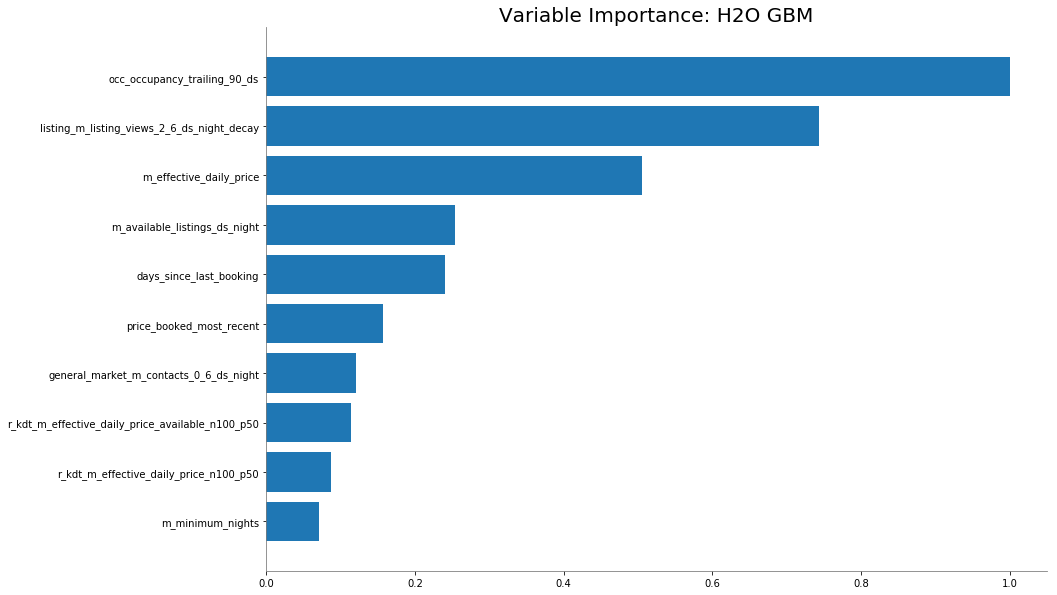

In [19]:
gbm_baseline.varimp_plot()


In [20]:
df_test["dim_is_requested"].asfactor()# Eval performance on the test data

perf_base_test = gbm_baseline.model_performance(df_test)


# Generate predictions on a test set 
pred = gbm_baseline.predict(df_test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [21]:
gbm_baseline

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_baseline.hex


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.09487101514895245
RMSE: 0.30801138801828815
LogLoss: 0.3099939298214721
Mean Per-Class Error: 0.1415156769112742
AUC: 0.9352958985109001
pr_auc: 0.884628850178733
Gini: 0.8705917970218002
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40150780279273307: 


,false,true,Error,Rate
false,76601.0,10089.0,0.1164,(10089.0/86690.0)
true,7201.0,35104.0,0.1702,(7201.0/42305.0)
Total,83802.0,45193.0,0.134,(17290.0/128995.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4015078,0.8023955,213.0
max f2,0.2237822,0.8537518,277.0
max f0point5,0.6040646,0.8294253,144.0
max accuracy,0.4885876,0.8706927,183.0
max precision,0.9969069,1.0,0.0
max recall,0.0079964,1.0,394.0
max specificity,0.9969069,1.0,0.0
max absolute_mcc,0.4368850,0.7038113,201.0
max min_per_class_accuracy,0.3556188,0.8579421,229.0
max mean_per_class_accuracy,0.3456974,0.8584843,232.0


Gains/Lift Table: Avg response rate: 32.80 %, avg score: 32.80 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100004,0.9791600,3.0491668,3.0491668,1.0,0.9878527,1.0,0.9878527,0.0304928,0.0304928,204.9166765,204.9166765
,2,0.0200008,0.9643337,3.0326209,3.0408938,0.9945736,0.9717629,0.9972868,0.9798078,0.0303274,0.0608202,203.2620899,204.0893832
,3,0.0300012,0.9511552,3.0278935,3.0365604,0.9930233,0.9576857,0.9958656,0.9724338,0.0302801,0.0911003,202.7893509,203.6560391
,4,0.0400016,0.9388492,3.0137113,3.0308481,0.9883721,0.9451128,0.9939922,0.9656035,0.0301383,0.1212386,201.3711338,203.0848128
,5,0.0500019,0.9257390,3.0089839,3.0264753,0.9868217,0.9323286,0.9925581,0.9589485,0.0300910,0.1513296,200.8983947,202.6475292
,6,0.1000039,0.8583259,2.9380731,2.9822742,0.9635659,0.8926472,0.9780620,0.9257979,0.1469093,0.2982390,193.8073092,198.2274192
,7,0.1500058,0.7819459,2.7664688,2.9103391,0.9072868,0.8211174,0.9544703,0.8909044,0.1383288,0.4365678,176.6468823,191.0339069
,8,0.2,0.6944494,2.4959763,2.8067604,0.8185765,0.7390834,0.9205008,0.8529535,0.1247843,0.5613521,149.5976330,180.6760430
,9,0.3000039,0.4959936,1.9878676,2.5337891,0.6519380,0.5960985,0.8309775,0.7673330,0.1987945,0.7601466,98.7867635,153.3789112
,10,0.4,0.3171209,1.1991955,2.2001536,0.3932863,0.4026878,0.7215590,0.6761752,0.1199149,0.8800615,19.9195519,120.0153646




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.1132435552599738
RMSE: 0.3365167978867828
LogLoss: 0.35846771701394653
Mean Per-Class Error: 0.17529963942367166
AUC: 0.9067267101867199
pr_auc: 0.8322801203322974
Gini: 0.8134534203734398
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3845840377079885: 


,false,true,Error,Rate
false,73738.0,12952.0,0.1494,(12952.0/86690.0)
true,8642.0,33663.0,0.2043,(8642.0/42305.0)
Total,82380.0,46615.0,0.1674,(21594.0/128995.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3845840,0.7571525,219.0
max f2,0.1777311,0.8271314,299.0
max f0point5,0.6152357,0.7783275,139.0
max accuracy,0.5030738,0.8399860,177.0
max precision,0.9966918,1.0,0.0
max recall,0.0064076,1.0,396.0
max specificity,0.9966918,1.0,0.0
max absolute_mcc,0.4342852,0.6324447,202.0
max min_per_class_accuracy,0.3396247,0.8237744,235.0
max mean_per_class_accuracy,0.3117353,0.8247004,246.0


Gains/Lift Table: Avg response rate: 32.80 %, avg score: 32.71 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100004,0.9780796,3.0326209,3.0326209,0.9945736,0.9874746,0.9945736,0.9874746,0.0303274,0.0303274,203.2620899,203.2620899
,2,0.0200008,0.9631470,3.0042566,3.0184387,0.9852713,0.9704528,0.9899225,0.9789637,0.0300437,0.0603711,200.4256557,201.8438728
,3,0.0300012,0.9493703,2.9711648,3.0026808,0.9744186,0.9560684,0.9847545,0.9713319,0.0297128,0.0900839,197.1164825,200.2680760
,4,0.0400016,0.9358641,2.9286183,2.9841651,0.9604651,0.9426741,0.9786822,0.9641675,0.0292873,0.1193712,192.8618312,198.4165148
,5,0.0500019,0.9226544,2.9049814,2.9683284,0.9527132,0.9292162,0.9734884,0.9571772,0.0290509,0.1484222,190.4981360,196.8328390
,6,0.1000039,0.8507648,2.7631596,2.8657440,0.9062016,0.8873982,0.9398450,0.9222877,0.1381633,0.2865855,176.3159650,186.5744020
,7,0.1500058,0.7728005,2.5702821,2.7672567,0.8429457,0.8130175,0.9075452,0.8858643,0.1285191,0.4151046,157.0282124,176.7256722
,8,0.2,0.6842959,2.2912486,2.6482685,0.7514343,0.7295456,0.8685220,0.8467892,0.1145491,0.5296537,129.1248588,164.8268526
,9,0.3000039,0.4923882,1.8335183,2.3766781,0.6013178,0.5882358,0.7794517,0.7606025,0.1833589,0.7130126,83.3518341,137.6678113
,10,0.4,0.3212663,1.2315807,2.0904148,0.4039073,0.4032662,0.6855692,0.6712719,0.1231533,0.8361659,23.1580653,109.0414845



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.8334687,0.0005715,0.8333914,0.8333462,0.8329095,0.8349981,0.8326985
auc,0.9067576,0.0005484,0.9059638,0.9063775,0.9064513,0.90822,0.9067755
err,0.1665313,0.0005715,0.1666086,0.1666538,0.1670906,0.1650019,0.1673016
err_count,4296.4,25.268953,4304.0,4309.0,4336.0,4229.0,4304.0
f0point5,0.7376350,0.0015593,0.7405623,0.7373337,0.7376352,0.7387921,0.7338516
f1,0.7575163,0.0015567,0.7543098,0.7577989,0.7573044,0.7611949,0.7569735
f2,0.7785320,0.0038906,0.7685775,0.7794325,0.7780513,0.7849988,0.7815998
lift_top_group,3.0326896,0.0109275,3.0082207,3.0358522,3.0400655,3.024925,3.0543847
logloss,0.3584631,0.0009239,0.3598625,0.3590756,0.3590411,0.3560468,0.3582897
max_per_class_error,0.2067773,0.0057167,0.2216070,0.2054455,0.2074742,0.1982871,0.2010727


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-02-09 10:56:34,8 min 1.487 sec,0.0,0.4694696,0.6327234,0.5,0.0,1.0,0.6720416
,2019-02-09 10:56:35,8 min 2.529 sec,5.0,0.4264256,0.5452959,0.8247671,0.6780903,2.7473158,0.2563665
,2019-02-09 10:56:36,8 min 3.368 sec,10.0,0.4053610,0.5025732,0.8363584,0.7046534,2.8131631,0.2461646
,2019-02-09 10:56:37,8 min 4.135 sec,15.0,0.3926571,0.4760237,0.8470919,0.7253727,2.8695259,0.2339315
,2019-02-09 10:56:38,8 min 4.953 sec,20.0,0.3844393,0.4586160,0.8547083,0.7417552,2.9380731,0.2255049
---,---,---,---,---,---,---,---,---,---
,2019-02-09 10:57:48,9 min 15.489 sec,480.0,0.3095112,0.3125483,0.9340137,0.8828378,3.0491668,0.1361913
,2019-02-09 10:57:49,9 min 16.236 sec,485.0,0.3091792,0.3119995,0.9343129,0.8828928,3.0491668,0.1351448
,2019-02-09 10:57:50,9 min 16.973 sec,490.0,0.3087654,0.3112792,0.9346624,0.8837744,3.0491668,0.1338501
,2019-02-09 10:57:50,9 min 17.713 sec,495.0,0.3083997,0.3106716,0.9349607,0.8845994,3.0491668,0.1335168



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
occ_occupancy_trailing_90_ds,18916.9316406,1.0,0.2330934
listing_m_listing_views_2_6_ds_night_decay,14071.3095703,0.7438474,0.1733859
m_effective_daily_price,9547.7128906,0.5047178,0.1176464
m_available_listings_ds_night,4812.9409180,0.2544250,0.0593048
days_since_last_booking,4555.4282227,0.2408122,0.0561317
---,---,---,---
m_reviews,147.3777008,0.0077908,0.0018160
cancel_policy,141.9416656,0.0075034,0.0017490
general_market_m_is_booked_0_6_ds_night,117.6454086,0.0062191,0.0014496
ds,89.5945511,0.0047362,0.0011040



See the whole table with table.as_data_frame()


```
#max absolute_mcc .7038113 MCC is our metric for now onwards. 
#Confusion Matrix (Act/Pred) Absolute values 

       false        true  
#false  76601.0     10089.0 
#true   7201.0      35104.0 
````
Focusing on bringing up TP first we easy to understand features. With our base model, for 35,000 TP, we are missing on 10,089 counts and the model is mis-counting 7201 as True bookings - MCC value is 0.7038. Model resuls on the test set is  the same.(below)


```
ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.11501490155810737
RMSE: 0.339138469593332
LogLoss: 0.36287464989218143
Mean Per-Class Error: 0.1766299710658492
AUC: 0.9051766735707953
pr_auc: 0.8266543623561153
Gini: 0.8103533471415907
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38169599144289085:
       false    true    Error    Rate
-----  -------  ------  -------  ----------------
false  15631    2879    0.1555   (2879.0/18510.0)
true   1829     7302    0.2003   (1829.0/9131.0)
Total  17460    10181   0.1703   (4708.0/27641.0)
Maximum Metrics: Maximum metrics at their respective thresholds

metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.381696     0.756214  218
max f2                       0.171408     0.830243  298
max f0point5                 0.573478     0.772972  152
max accuracy                 0.492428     0.838428  180
max precision                0.99674      1         0
max recall                   0.00822544   1         394
max specificity              0.99674      1         0
max absolute_mcc             0.435678     0.630773  200
max min_per_class_accuracy   0.346315     0.822801  230
max mean_per_class_accuracy  0.35347      0.82337   228
Gains/Lift Table: Avg response rate: 33.03 %, avg score: 32.81 %
```
   

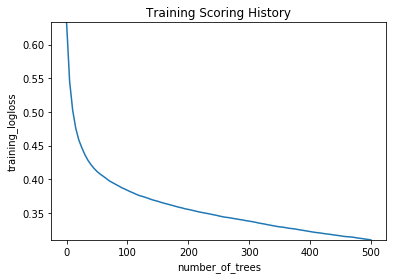

In [23]:
#df_all = data.as_data_frame(use_pandas=True, header=True)
#df_all.head
gbm_baseline.plot() #overfitting

### Feature (Engineer)ing


In [4]:
h2o.remove_all
data_path = "https://s3.amazonaws.com/challengeprivate/TH_data_challenge.tsv"
#data = pd.read_csv(data_path ,delimiter='\t',encoding='utf-8')
data = h2o.import_file(data_path, destination_frame = "airbnb_challenge_raw")

data["ds_night"].table()


Parse progress: |█████████████████████████████████████████████████████████| 100%


ds_night,Counts
1.42007e+12,515
1.42016e+12,575
1.42024e+12,612
1.42033e+12,612
1.42042e+12,646
1.4205e+12,615
1.42059e+12,614
1.42068e+12,645
1.42076e+12,645
1.42085e+12,619


In [5]:
# Find number of dim_requested by market
dim_requested = data.group_by("dim_market")
dim_requested.count()
dim_requested.get_frame()

dim_market,nrow
Los Angeles,52698
Paris,113704
San Francisco,17877


In [6]:
# Find number of dim_requested per month based on the market
cols = ["dim_market","month"]
dim_requested_by_ds_month = data.group_by(by=cols).count(na ="all")
dim_requested_by_ds_month.get_frame()


ValueError: 'month' is not in list

In [ ]:
# build year, month, day. Use month as factor. drop year. Use day.

def timedatemap(ts):
    loc_day = pd.to_datetime([int(ts)], unit="s")[0]

    year = int(str(loc_day).split(" ")[0].split("-")[0])
    month = int(str(loc_day).split(" ")[0].split("-")[1])
    day = int(str(loc_day).split(" ")[0].split("-")[2])
    return(pd.DataFrame([{"year": year, "month":month, "day":day}]))
    #return year, month, day


    
dd = pd.DataFrame()
for loc in time_df["ds_conv"]:
    dd = dd.append(timedatemap(loc), ignore_index=True)
dd.describe


data.cbind(data_mx)

#ata['newcol1', 'newcol2','newcol3'] = h2o.H2OFrame(dd, column_names=['newcol1', 'newcol2','newcol3'])
data_mx = h2o.H2OFrame(dd)
data.cbind(data_mx)
print(data_mx.shape)
print(data.shape)
h2o.export_file( data, path= 'data_ymd_c0.csv')


###########################################################################

# Some basic information about the training/vali/test data                #

###########################################################################

print('# shapet', data.shape)
print("# column list", data.columns)
print("# column list", data.sample(10))
print("# info() " ,data.info())
print("# Statistical Summary", data.datadescribe().transpose())
print("# Target class distribution", data.groupby('Survived').size())
print("# check for missing values", data.isnull().any())
print("# count the number of NaN values in each column", data.isnull().sum())




In [33]:
#data = h2o.import_file('data_ymd_c0.csv', destination_frame = "airbnb_challenge_ymd")


Parse progress: |█████████████████████████████████████████████████████████| 100%


dim_is_requested,ds_night,ds,id_listing_anon,id_user_anon,m_effective_daily_price,m_pricing_cleaning_fee,dim_market,dim_lat,dim_lng,dim_room_type,dim_person_capacity,dim_is_instant_bookable,m_checkouts,m_reviews,days_since_last_booking,cancel_policy,image_quality_score,m_total_overall_rating,m_professional_pictures,dim_has_wireless_internet,ds_night_day_of_week,ds_night_day_of_year,ds_checkin_gap,ds_checkout_gap,occ_occupancy_plus_minus_7_ds_night,occ_occupancy_plus_minus_14_ds_night,occ_occupancy_trailing_90_ds,m_minimum_nights,m_maximum_nights,price_booked_most_recent,p2_p3_click_through_score,p3_inquiry_score,listing_m_listing_views_2_6_ds_night_decay,general_market_m_unique_searchers_0_6_ds_night,general_market_m_contacts_0_6_ds_night,general_market_m_reservation_requests_0_6_ds_night,general_market_m_is_booked_0_6_ds_night,m_available_listings_ds_night,kdt_score,r_kdt_listing_views_0_6_avg_n100,r_kdt_n_active_n100,r_kdt_n_available_n100,r_kdt_m_effective_daily_price_n100_p50,r_kdt_m_effective_daily_price_available_n100_p50,r_kdt_m_effective_daily_price_booked_n100_p50
false,1.4205e+12,1.41791e+12,0AE0C7CC-A8A4-425F-9CCC-8B25DBB94F4D,DCC74708-D5C4-47B2-BC0C-97BF5ABFCD99,110,60,Los Angeles,34.0539,-118.363,Private room,2,false,24,19,320,4,0.830959,74,16,1,2,6,0,7,nan,nan,0,5,90,92,NULL,NULL,0.133333,788.143,241.429,41.4286,1,9840,1.31429,1.79592,57,48,79,75,98
true,1.4218e+12,1.41921e+12,82FDDA07-6993-4CCA-8EE4-FC218D2C07C7,559D8981-0C75-4631-9582-A3B644BB5631,70,0,Los Angeles,34.1086,-118.209,Private room,2,true,105,55,3,3,0.967384,263,0,1,3,21,7,7,nan,nan,0.359551,1,1125,70,NULL,NULL,0.0666667,830.143,298,51.7143,1,9599,0.535714,2.69388,49,36,65,65,42
false,1.42188e+12,1.41929e+12,69B2069D-CF8F-49A7-B559-9619DBE86A7D,EE7901A6-79D5-4D69-BACF-E4BCA976A66A,125,0,Los Angeles,34.0772,-118.206,Private room,1,false,0,0,nan,3,0.485231,0,0,1,4,22,7,7,nan,nan,0,1,1125,nan,NULL,NULL,0,810.143,281,51.7143,1,9514,0.714286,2.77551,49,35,65,66.5,46
true,1.42284e+12,1.42024e+12,66BAADE6-9352-4D7C-B590-745899BD12B3,AF691F3D-525E-497C-B9C5-8750B097B04D,126.867,125,Los Angeles,34.0935,-118.247,Entire home/apt,6,false,0,0,nan,5,0.30931,0,0,1,1,33,7,7,0,0,0,3,1125,nan,NULL,NULL,0.733333,816.857,274.429,41.8571,1,9739,1.74468,4.57653,113,52,120,115,115
true,1.42379e+12,1.42119e+12,01E3589E-A50A-494B-8CB2-9645B29476D0,6733A1D9-D485-4EA7-B8D2-883EE8A363B9,210.714,200,Los Angeles,34.0975,-118.364,Entire home/apt,5,false,9,1,34,5,0.335816,5,0,1,5,44,7,7,0,0,0.133333,2,1125,296,NULL,NULL,1,1347.43,419.429,78.8571,1,9114,1.2,4.87755,97,57,150,157.5,164.5
false,1.42465e+12,1.42206e+12,B6222B7A-4D2D-4770-9B2F-9C2E711D953F,F61E18D6-5A67-43EC-9553-8BE04DD02B54,36,35,Los Angeles,33.9901,-117.91,Private room,3,false,6,2,33,5,0.727793,5,0,1,1,54,7,7,0,0,0.457447,1,1125,36,NULL,NULL,0.0666667,1103.57,384.571,58.8571,1,9093,0.666667,1.30612,84,71,60,60,40
false,1.42534e+12,1.42275e+12,63974898-6E06-4CA9-B6A1-D315D28E64AA,4D33F8F6-A185-4866-8233-6DEE13D699E7,109,0,Los Angeles,34.0685,-118.347,Private room,2,false,0,0,nan,3,0.069733,0,0,0,2,62,7,7,0,0,0,1,1125,nan,NULL,NULL,0,935.143,259.571,36.2857,1,9706,0.5,0.367347,29,21,89,93.5,65
true,1.42534e+12,1.42275e+12,E073FC50-8B2A-485F-8DAA-E66D0E936424,5EAAD1FA-DEBF-46DE-92AB-32C6A1DCB074,340,150,Los Angeles,34.1065,-118.301,Entire home/apt,8,false,19,8,5,5,0.85905,34,0,1,2,62,7,7,0,0.0833333,0.225352,1,365,389,NULL,NULL,1.06667,935.143,259.571,36.2857,1,9706,0.724138,0.897959,23,15,128,117.5,70
false,1.42595e+12,1.42335e+12,FA43F4DB-19EA-4945-B05B-D2D41C495863,78A46A22-C320-46F3-8810-34812A662896,29,0,Los Angeles,34.2151,-118.535,Shared room,6,false,23,6,1,3,0.409632,20,0,1,2,69,7,7,0,0,0.41,1,1125,29,NULL,NULL,0.4,1083.86,274.714,44.4286,1,9647,0.814815,1.7551,20,18,35,35,29
false,1.42603e+12,1.42344e+12,83114506-2EEB-4F1C-87D9-36CC26355AC7,D5CCFF5C-2846-4CFD-BD0D-EB11E6D2E9CE,1300,300,Los Angeles,34.104,-118.369,Entire home/apt,14,false,0,0,91,5,nan,0,0,1,3,70,7,7,0,0,0.0238095,2,29,1500,NULL,NULL,0.2,1104.71

<bound method H2OFrame.head of >

Idealy three models each trained on one market and stack them together. Here we will try for an ensumble model that uses different features (eventually using all featues). CV = 10, keeping CV results and we'll stack all resutls. This should solve few problems at the same time. 

In [ ]:
from sklearn import preprocessing

def normalize(df):
    """ Standardization of numeric fields, where all values will have mean of zero 
      and standard deviation of one. (z-score)

      Args:
        dataset: A `Pandas.Dataframe` 
    """
    x = df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_normalize= pd.DataFrame(x_scaled)
    #h2o_obj = h2o.H2OFrame(df_normalize)
    return df_normalize

data["m_reviews_new"] = 3*data["m_reviews"]

tempdf = data["ds"].as_data_frame()
test_ = normalize(tempdf)
data['newcol'] = h2o.H2OFrame(test_, column_names=["newcol"])

#np.log(2+110.12)

###########################################################################

# Drop multi collinear levels and no longer required                      #

###########################################################################

trainData = trainData.drop(columns=dropColumns)

#dropColumns = ['x2']



In [7]:
# Filter to relevant columns
x1 = [ 'dim_is_requested',
'ds', 
'id_listing_anon', 
'm_effective_daily_price',
'm_pricing_cleaning_fee', 
'dim_market', 
#use kdt instead 'dim_lat', 
#use kdt instead 'dim_lng', 
#needs process  'dim_room_type',
'dim_person_capacity', #num
'dim_is_instant_bookable', #bool
'm_checkouts',  #num
#'m_reviews', #use m_checkouts
'days_since_last_booking', #num
'cancel_policy', #cat 3-9
'image_quality_score', #num
#'m_total_overall_rating', #use m_checkouts instead
'm_professional_pictures', #num
'dim_has_wireless_internet', #bool
##'ds_night_day_of_week', #bool
'ds_night_day_of_year', #bool
'ds_checkin_gap', #num 0-6
#'ds_checkout_gap', #num 0-6
#'occ_occupancy_plus_minus_7_ds_night', #num 
'occ_occupancy_plus_minus_14_ds_night', #num 
'occ_occupancy_trailing_90_ds', #num 
'm_minimum_nights', #num 
##'m_maximum_nights', 
'price_booked_most_recent', #num 
#'p2_p3_click_through_score', #num 
'p3_inquiry_score',  #num 
'listing_m_listing_views_2_6_ds_night_decay', #num 
#'general_market_m_unique_searchers_0_6_ds_night',#num 
#'general_market_m_contacts_0_6_ds_night',# use gm_m_ds_night instead
'general_market_m_reservation_requests_0_6_ds_night',#num 
'general_market_m_is_booked_0_6_ds_night',
'm_available_listings_ds_night',
'kdt_score', 
'r_kdt_listing_views_0_6_avg_n100', 
##'r_kdt_n_active_n100', 
'r_kdt_n_available_n100', 
#'r_kdt_m_effective_daily_price_n100_p50', use _n100_p50 instead
'r_kdt_m_effective_daily_price_available_n100_p50',
'r_kdt_m_effective_daily_price_booked_n100_p50'
]

### Generate a 2-model ensemble (GBM + RF)

In [8]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data_train_c0.csv")
test = h2o.import_file("data_valid_c0.csv")
test_ = h2o.import_file("data_test_c0.csv") #for the final evaluation




# features and target
target = "dim_is_requested"

train[target] = train[target].asfactor()
test[target] = test[target].asfactor()
test_[target] = test_[target].asfactor()

# features and target

x = x1 #train.columns

y = target
x.remove(y)



Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [ ]:
## 2-model ensemble (GBM + RF)

In [48]:
#gbm

from h2o.estimators.gbm import H2OGradientBoostingEstimator
#  using the `categorical_encoding` parameter
encoding = "one_hot_explicit"  



# Number of CV folds (to generate level-one data for stacking)
nfolds = 5


# Train and cross-validate a GBM
my_gbm = H2OGradientBoostingEstimator(distribution="bernoulli",
                                      ntrees=10,
                                      max_depth=3,
                                      min_rows=2,
                                      learn_rate=0.2,
                                      nfolds=nfolds,
                                      fold_assignment="Modulo",
                                      keep_cross_validation_predictions=True,
                                      #categorical_encoding = encoding,
                                      seed=1234)
my_gbm.train(x=x, y=y, training_frame=train)



gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [49]:
my_gbm.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32031374764843784: 


,false,true,Error,Rate
false,61913.0,24777.0,0.2858,(24777.0/86690.0)
true,9062.0,33243.0,0.2142,(9062.0/42305.0)
Total,70975.0,58020.0,0.2623,(33839.0/128995.0)


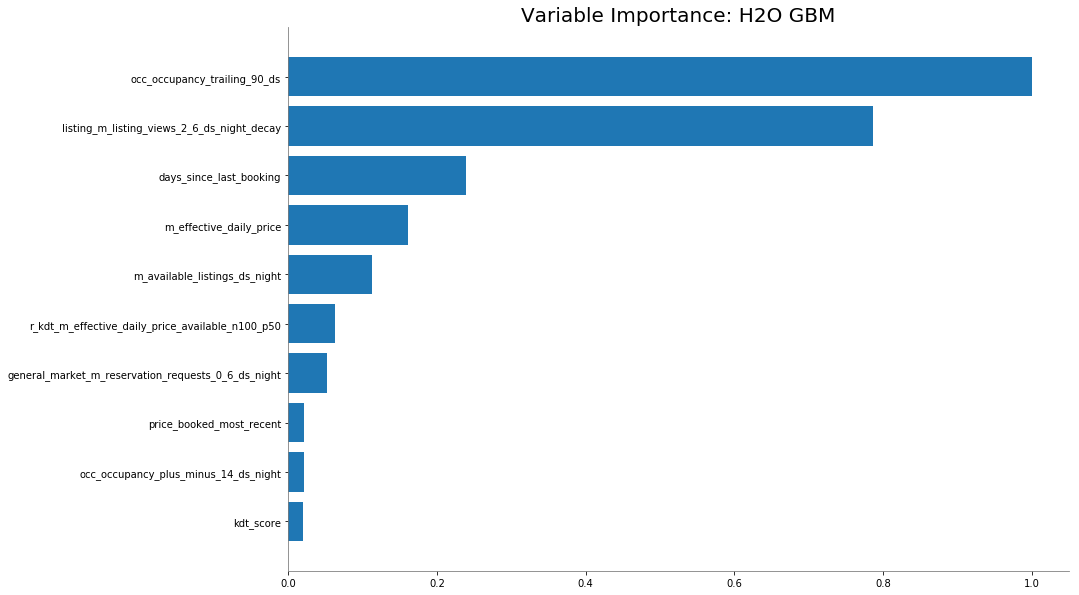

In [50]:
my_gbm.varimp_plot()

In [51]:
my_gbm.cross_validation_metrics_summary()

Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.7432924,0.0052723,0.7417729,0.7465405,0.7545641,0.7419667,0.7316175
auc,0.8264095,0.0033043,0.823414,0.8314934,0.8315452,0.8261065,0.8194885
err,0.2567076,0.0052723,0.2582271,0.2534594,0.2454359,0.2580332,0.2683825
err_count,6622.8,136.02014,6662.0,6539.0,6332.0,6657.0,6924.0
f0point5,0.6121064,0.0064518,0.6060025,0.6152468,0.6276523,0.6107302,0.6009005
f1,0.6621107,0.0042463,0.6549974,0.6684582,0.6696922,0.6607898,0.6566157
f2,0.7211264,0.0045282,0.7126116,0.7317452,0.7177681,0.7197886,0.7237188
lift_top_group,2.7638042,0.0304638,2.802054,2.8157191,2.716399,2.7737358,2.7111132
logloss,0.4886153,0.0024079,0.4885599,0.4840807,0.4869058,0.4890585,0.4944715
max_per_class_error,0.2683931,0.0100011,0.2655202,0.2702345,0.2461539,0.2694638,0.2905934


### Train and cross-validate a RF

In [53]:
my_rf = H2ORandomForestEstimator(ntrees=50, #from basemodel vs ntree plot recommend running for 250
                                 nfolds=nfolds,
                                 fold_assignment="Modulo",
                                 keep_cross_validation_predictions=True, #removed encodoing on rf -overfitting
                                 seed=1234)
my_rf.train(x=x, y=y, training_frame=train)




drf Model Build progress: |███████████████████████████████████████████████| 100%


### Train a stacked ensemble using the GBM and RF above


In [54]:
ensemble = H2OStackedEnsembleEstimator(model_id="airbnb_ensemble_binomial",
                                       base_models=[my_gbm, my_rf])
ensemble.train(x=x, y=y, training_frame=train)

# Eval ensemble performance on the test data
perf_stack_test = ensemble.model_performance(test)

# Compare to base learner performance on the test set
perf_gbm_test = my_gbm.model_performance(test)
perf_rf_test = my_rf.model_performance(test)
baselearner_best_auc_test = max(perf_gbm_test.auc(), perf_rf_test.auc())
stack_auc_test = perf_stack_test.auc()
print("Best Base-learner Test AUC:  {0}".format(baselearner_best_auc_test))
print("Ensemble Test AUC:  {0}".format(stack_auc_test))

# Generate predictions on the final test set 
pred = ensemble.predict(test_)


stackedensemble Model Build progress: |███████████████████████████████████| 100%
Best Base-learner Test AUC:  0.9003599471448196
Ensemble Test AUC:  0.9003816860226074
stackedensemble prediction progress: |████████████████████████████████████| 100%


/home/scv/.local/lib/python3.7/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'p3_inquiry_score' has levels not trained on: [0.02346153846153846, 0.023689320388349516, 0.024, 0.03219512195121951, 0.03428571428571429, 0.03676767676767677, 0.03882352941176471, 0.03913978494623656, 0.039585492227979274, 0.04176100628930818, 0.04246696035242291, 0.04265486725663717, 0.04293255131964809, 0.043278688524590166, 0.04379266750948167, 0.04422960725075529, 0.04461538461538462, 0.045048543689320396, 0.04534704370179949, 0.047070707070707075, 0.049090909090909095, 0.049357142857142856, 0.049722589167767506, 0.04981132075471698, 0.04992481203007519, 0.05014729950900164, 0.05056105610561056, 0.050687022900763365, 0.052286689419795224, 0.05236363636363637, 0.0526984126984127, 0.05311827956989247, 0.05324200913242009, 0.05337883959044369, 0.05346733668341709, 0.05368421052631579, 0.05391304347826087, 0.05540772532188841, 0.05546368715083799, 0.05564835164835165, 0.055766423357

In [55]:
ensemble

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  airbnb_ensemble_binomial
No model summary for this model


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.021319259634135133
RMSE: 0.14601116270386705
LogLoss: 0.11525424453944319
Null degrees of freedom: 128994
Residual degrees of freedom: 128993
Null deviance: 163236.3109288572
Residual deviance: 29734.44254873095
AIC: 29738.44254873095
AUC: 0.9983847262453913
pr_auc: 0.9913142268046848
Gini: 0.9967694524907826
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47631019194222124: 


,false,true,Error,Rate
false,85827.0,863.0,0.01,(863.0/86690.0)
true,1291.0,41014.0,0.0305,(1291.0/42305.0)
Total,87118.0,41877.0,0.0167,(2154.0/128995.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4763102,0.9744126,194.0
max f2,0.3489186,0.9786570,227.0
max f0point5,0.6035536,0.9816842,163.0
max accuracy,0.4763102,0.9833017,194.0
max precision,0.9737365,1.0,0.0
max recall,0.0467451,1.0,373.0
max specificity,0.9737365,1.0,0.0
max absolute_mcc,0.4763102,0.9620475,194.0
max min_per_class_accuracy,0.3830349,0.9811858,218.0
max mean_per_class_accuracy,0.4021934,0.9815346,213.0


Gains/Lift Table: Avg response rate: 32.80 %, avg score: 33.69 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100004,0.9669651,3.0491668,3.0491668,1.0,0.9702184,1.0,0.9702184,0.0304928,0.0304928,204.9166765,204.9166765
,2,0.0200008,0.9627629,3.0491668,3.0491668,1.0,0.9647899,1.0,0.9675041,0.0304928,0.0609857,204.9166765,204.9166765
,3,0.0300012,0.9594623,3.0491668,3.0491668,1.0,0.9611249,1.0,0.9653777,0.0304928,0.0914785,204.9166765,204.9166765
,4,0.0400093,0.9561862,3.0491668,3.0491668,1.0,0.9577641,1.0,0.9634732,0.0305165,0.1219950,204.9166765,204.9166765
,5,0.0500019,0.9532893,3.0491668,3.0491668,1.0,0.9547412,1.0,0.9617281,0.0304692,0.1524642,204.9166765,204.9166765
,6,0.1000039,0.9376274,3.0491668,3.0491668,1.0,0.9455666,1.0,0.9536474,0.1524642,0.3049285,204.9166765,204.9166765
,7,0.1500058,0.9180417,3.0491668,3.0491668,1.0,0.9283125,1.0,0.9452024,0.1524642,0.4573927,204.9166765,204.9166765
,8,0.2,0.8888279,3.0486940,3.0490486,0.9998449,0.9045949,0.9999612,0.9350517,0.1524170,0.6098097,204.8693953,204.9048576
,9,0.3000039,0.6830336,3.0141841,3.0374268,0.9885271,0.8204971,0.9961498,0.8968659,0.3014301,0.9112398,201.4184077,203.7426776
,10,0.4,0.1520299,0.8630520,2.4938542,0.2830452,0.3381655,0.8178805,0.7571962,0.0863019,0.9975417,-13.6947991,149.3854154


In [ ]:
# # Specify GBM hyperparameters for the grid
# hyper_params = {"learn_rate": [0.01, 0.03],
#                 "max_depth": [3, 4, 5, 6, 9],
#                 "sample_rate": [0.7, 0.8, 0.9, 1.0],
#                 "col_sample_rate": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}
# search_criteria = {"strategy": "RandomDiscrete", "max_models": 3, "seed": 1234}
# 
# # Train the grid
# grid = H2OGridSearch(model=H2OGradientBoostingEstimator(ntrees=10,
#                                                         seed=1,
#                                                         nfolds=nfolds,
#                                                         fold_assignment="Modulo",
#                                                         keep_cross_validation_predictions=True),
#                      hyper_params=hyper_params,
#                      search_criteria=search_criteria,
#                      grid_id="gbm_grid_binomial")
# grid.train(x=x, y=y, training_frame=train)

### One line takeout:
MCC improved from 0.71 from our basemodel to 0.962 on the final test data in our ensumble model. 
#### More:
The training of the ensumble took significantly lower time (used 4 CPUs and at max 12GB of memory). 

In [56]:
h2o.cluster().shutdown(prompt=True)


Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:5151 (Y/N)? Y
H2O session _sid_a03c closed.


###  Hyperparameter Opt
increase nfolds to 10 for stacking and ntrees to 50 for gbm.

In [ ]:
gbm_baseline.plot()

In [10]:
#gbm

from h2o.estimators.gbm import H2OGradientBoostingEstimator
#  using the `categorical_encoding` parameter
encoding = "one_hot_explicit"  



# Number of CV folds (to generate level-one data for stacking)
nfolds = 10


# Train and cross-validate a GBM
my_gbm = H2OGradientBoostingEstimator(distribution="bernoulli",
                                      ntrees=50,
                                      max_depth=3,
                                      min_rows=2,
                                      learn_rate=0.2,
                                      nfolds=nfolds,
                                      fold_assignment="Modulo",
                                      keep_cross_validation_predictions=True,
                                      #categorical_encoding = encoding,
                                      seed=1234)
my_gbm.train(x=x, y=y, training_frame=train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [11]:

my_rf = H2ORandomForestEstimator(ntrees=50, #from basemodel vs ntree plot recommend running for 250
                                 nfolds=nfolds,
                                 fold_assignment="Modulo",
                                 keep_cross_validation_predictions=True, #removed encodoing on rf -overfitting
                                 seed=1234)
my_rf.train(x=x, y=y, training_frame=train)


drf Model Build progress: |███████████████████████████████████████████████| 100%


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35145120498100196: 


,false,true,Error,Rate
false,68314.0,18376.0,0.212,(18376.0/86690.0)
true,9063.0,33242.0,0.2142,(9063.0/42305.0)
Total,77377.0,51618.0,0.2127,(27439.0/128995.0)


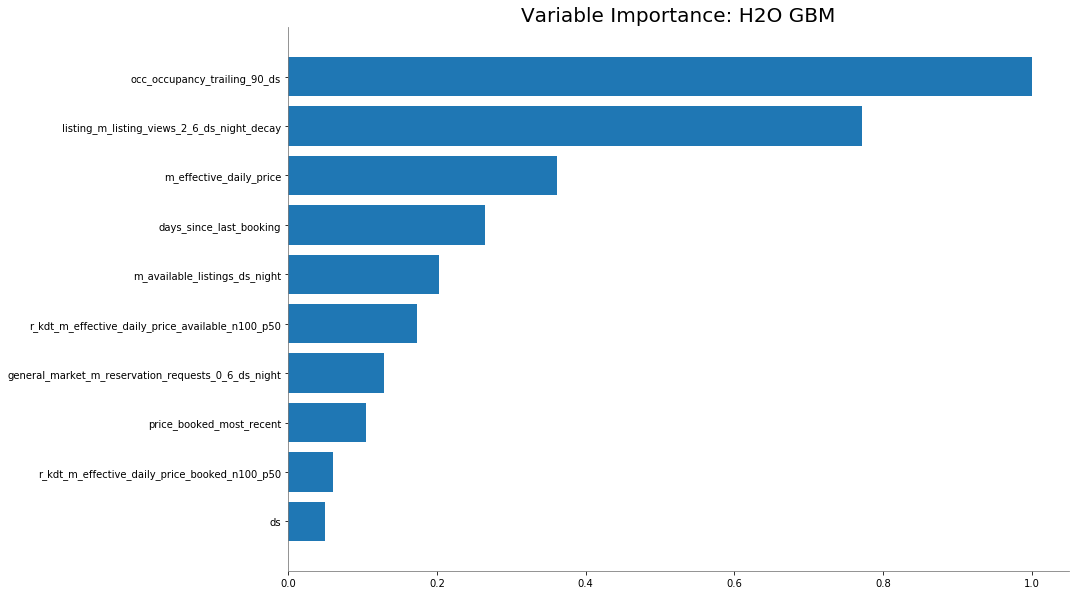

None
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
accuracy,0.7861855,0.0026003,0.7824806,0.7906977,0.7903876,0.7855039,0.7814729,0.7888983,0.7838592,0.7914567,0.7817661,0.7853322
auc,0.8649648,0.0026407,0.861857,0.8676187,0.8685551,0.8693664,0.8607262,0.8629332,0.8647944,0.8709299,0.8634155,0.8594516
err,0.2138145,0.0026003,0.2175194,0.2093023,0.2096124,0.2144961,0.2185271,0.2111016,0.2161408,0.2085433,0.2182340,0.2146678
err_count,2758.1,33.54467,2806.0,2700.0,2704.0,2767.0,2819.0,2723.0,2788.0,2690.0,2815.0,2769.0
f0point5,0.6671859,0.0040660,0.6587974,0.6744723,0.6736808,0.6647838,0.6679451,0.6675859,0.6610845,0.6765472,0.6617231,0.6652388
f1,0.7040308,0.0045783,0.6994430,0.7079186,0.7096220,0.7115605,0.7012822,0.6980149,0.704034,0.7152234,0.6994127,0.6937963
f2,0.7452906,0.0081660,0.7454338,0.7448552,0.7496143,0.7654182,0.7381218,0.7313502,0.7529519,0.7585897,0.741655,0.7249157
lift_top_group,2.9762173,0.0358331,3.0324738,2.9952831,2.9938707,2.952291,2.8432732,2.9522436,3.023575,2.9953213,2.9964643,2.9773777
logloss,0.4277916,0.0030663,0.4294965,0.4238360,0.4240905,0.4230297,0.4361360,0.4281338,0.4272915,0.4228183,0.4292764,0.4338072
max_per_class_error,0.2282360,0.0086087,0.2203916,0.2283019,0.2211221,0.2245557,0.2350901,0.2445991,0.2188757,0.2094547,0.2272298,0.2527394



stackedensemble Model Build progress: |███████████████████████████████████| 100%
Best Base-learner Test AUC:  0.9003599471448196
Ensemble Test AUC:  0.9003758632679015
stackedensemble prediction progress: |████████████████████████████████████| 100%


/home/scv/.local/lib/python3.7/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'p3_inquiry_score' has levels not trained on: [0.02346153846153846, 0.023689320388349516, 0.024, 0.03219512195121951, 0.03428571428571429, 0.03676767676767677, 0.03882352941176471, 0.03913978494623656, 0.039585492227979274, 0.04176100628930818, 0.04246696035242291, 0.04265486725663717, 0.04293255131964809, 0.043278688524590166, 0.04379266750948167, 0.04422960725075529, 0.04461538461538462, 0.045048543689320396, 0.04534704370179949, 0.047070707070707075, 0.049090909090909095, 0.049357142857142856, 0.049722589167767506, 0.04981132075471698, 0.04992481203007519, 0.05014729950900164, 0.05056105610561056, 0.050687022900763365, 0.052286689419795224, 0.05236363636363637, 0.0526984126984127, 0.05311827956989247, 0.05324200913242009, 0.05337883959044369, 0.05346733668341709, 0.05368421052631579, 0.05391304347826087, 0.05540772532188841, 0.05546368715083799, 0.05564835164835165, 0.055766423357

In [12]:
print(my_gbm.confusion_matrix())
print(my_gbm.varimp_plot())
print(my_gbm.cross_validation_metrics_summary())

ensemble_hyper = H2OStackedEnsembleEstimator(model_id="airbnb_ensemble_binomial",
                                       base_models=[my_gbm, my_rf])
ensemble_hyper.train(x=x, y=y, training_frame=train)

# Eval ensemble performance on the test data
perf_stack_test = ensemble_hyper.model_performance(test)

# Compare to base learner performance on the test set
perf_gbm_test = my_gbm.model_performance(test)
perf_rf_test = my_rf.model_performance(test)
baselearner_best_auc_test = max(perf_gbm_test.auc(), perf_rf_test.auc())
stack_auc_test = perf_stack_test.auc()
print("Best Base-learner Test AUC:  {0}".format(baselearner_best_auc_test))
print("Ensemble Test AUC:  {0}".format(stack_auc_test))

# Generate predictions on the final test set 
pred_new = ensemble_hyper.predict(test_)

ensemble_hyper

In [13]:
ensemble_hyper

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  airbnb_ensemble_binomial
No model summary for this model


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.02103686471153066
RMSE: 0.14504090702808867
LogLoss: 0.11354547096881774
Null degrees of freedom: 128994
Residual degrees of freedom: 128993
Null deviance: 163236.3109288572
Residual deviance: 29293.59605524528
AIC: 29297.59605524528
AUC: 0.998384905526717
pr_auc: 0.9919762829553098
Gini: 0.996769811053434
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4761371101888196: 


,false,true,Error,Rate
false,85827.0,863.0,0.01,(863.0/86690.0)
true,1291.0,41014.0,0.0305,(1291.0/42305.0)
Total,87118.0,41877.0,0.0167,(2154.0/128995.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4761371,0.9744126,201.0
max f2,0.3259604,0.9786207,239.0
max f0point5,0.5950148,0.9817206,173.0
max accuracy,0.4761371,0.9833017,201.0
max precision,0.9748402,1.0,0.0
max recall,0.0456931,1.0,374.0
max specificity,0.9748402,1.0,0.0
max absolute_mcc,0.4761371,0.9620475,201.0
max min_per_class_accuracy,0.3821974,0.9813012,224.0
max mean_per_class_accuracy,0.4012866,0.9815404,219.0


Gains/Lift Table: Avg response rate: 32.80 %, avg score: 33.65 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100004,0.9681033,3.0491668,3.0491668,1.0,0.9712786,1.0,0.9712786,0.0304928,0.0304928,204.9166765,204.9166765
,2,0.0200008,0.9639947,3.0491668,3.0491668,1.0,0.9659771,1.0,0.9686278,0.0304928,0.0609857,204.9166765,204.9166765
,3,0.0300012,0.9607634,3.0491668,3.0491668,1.0,0.9623914,1.0,0.9665490,0.0304928,0.0914785,204.9166765,204.9166765
,4,0.0400093,0.9575527,3.0491668,3.0491668,1.0,0.9590994,1.0,0.9646855,0.0305165,0.1219950,204.9166765,204.9166765
,5,0.0500019,0.9547111,3.0491668,3.0491668,1.0,0.9561355,1.0,0.9629768,0.0304692,0.1524642,204.9166765,204.9166765
,6,0.1000039,0.9393105,3.0491668,3.0491668,1.0,0.9471222,1.0,0.9550495,0.1524642,0.3049285,204.9166765,204.9166765
,7,0.1500058,0.9199783,3.0491668,3.0491668,1.0,0.9301223,1.0,0.9467405,0.1524642,0.4573927,204.9166765,204.9166765
,8,0.2,0.8910252,3.0486940,3.0490486,0.9998449,0.9066618,0.9999612,0.9367220,0.1524170,0.6098097,204.8693953,204.9048576
,9,0.3000039,0.6848673,3.0141841,3.0374268,0.9885271,0.8227996,0.9961498,0.8987469,0.3014301,0.9112398,201.4184077,203.7426776
,10,0.4,0.1497276,0.8630520,2.4938542,0.2830452,0.3369574,0.8178805,0.7583050,0.0863019,0.9975417,-13.6947991,149.3854154


gbm Model Build progress: |███████████████████████████████████████████████| 100%
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3612904047997025: 


,false,true,Error,Rate
false,71143.0,15547.0,0.1793,(15547.0/86690.0)
true,8457.0,33848.0,0.1999,(8457.0/42305.0)
Total,79600.0,49395.0,0.1861,(24004.0/128995.0)


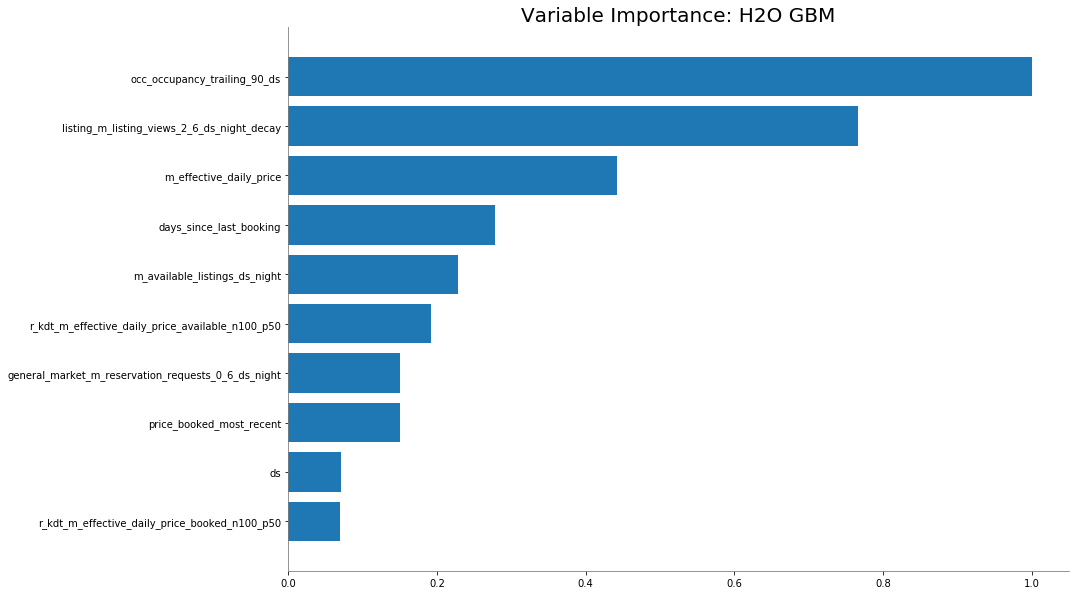

None
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
accuracy,0.8065894,0.0033792,0.8051163,0.814031,0.8034108,0.8168217,0.8013178,0.8083572,0.8044034,0.8035507,0.8034731,0.8054113
auc,0.8852918,0.0021995,0.8828459,0.8865751,0.8867688,0.8893049,0.8824659,0.8826603,0.8841203,0.8898221,0.8881493,0.8802054
err,0.1934107,0.0033792,0.1948837,0.185969,0.1965891,0.1831783,0.1986822,0.1916428,0.1955966,0.1964493,0.1965269,0.1945887
err_count,2494.9,43.568855,2514.0,2399.0,2536.0,2363.0,2563.0,2472.0,2523.0,2534.0,2535.0,2510.0
f0point5,0.6955150,0.0056673,0.6899768,0.7095531,0.6897520,0.7120810,0.6934072,0.6971345,0.6895699,0.6897817,0.6901791,0.6937150
f1,0.7286956,0.0043813,0.7259049,0.7320451,0.7305567,0.7376485,0.7293844,0.7183869,0.7263260,0.7381150,0.728848,0.7197409
f2,0.7654535,0.0099601,0.7657803,0.7560098,0.7764929,0.7651204,0.7692993,0.7409757,0.7672212,0.7937319,0.7721071,0.7477958
lift_top_group,3.0115774,0.0196415,3.0324738,3.018868,3.0174446,2.9995277,2.9588535,3.0482514,2.9997675,2.9719203,3.0436528,3.0250156
logloss,0.3947479,0.0030778,0.3969654,0.3919558,0.392457,0.3894944,0.4019903,0.3965569,0.3957588,0.3909434,0.389723,0.4016343
max_per_class_error,0.2136644,0.0105100,0.2051098,0.2271226,0.2000462,0.2153992,0.2015719,0.2431589,0.2028571,0.2123812,0.1967440,0.2322535



drf Model Build progress: |███████████████████████████████████████████████| 100%
stackedensemble Model Build progress: |███████████████████████████████████| 100%
Best Base-learner Test AUC:  0.9055506925760138
Ensemble Test AUC:  0.905999653080156
stackedensemble prediction progress: |████████████████████████████████████| 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  airbnb_ensemble_binomial_hyper
No model summary for this model


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.02638026151625987
RMSE: 0.16242001575009118
LogLoss: 0.1274214069837937
Null degrees of freedom: 128994
Residual degrees of freedom: 128992
Null deviance: 163236.3109288572
Residual deviance: 32873.44878774894
AIC: 32879.44878774894
AUC: 0.9970614337388013
pr_auc: 0.9896576755336781
Gini: 0.9941228674776026
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46456130993845873: 


,false,true,Error,Rate
false,85309.0,1381.0,0.0159,(1381.0/86690.0)
true,1668.0,40637.0,0.0394,(1668.0/42305.0)
Total,86977.0,42018.0,0.0236,(3049.0/128995.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4645613,0.9638414,201.0
max f2,0.3279310,0.9697726,237.0
max f0point5,0.6091272,0.9738189,160.0
max accuracy,0.4645613,0.9763634,201.0
max precision,0.9759184,1.0,0.0
max recall,0.0466219,1.0,371.0
max specificity,0.9759184,1.0,0.0
max absolute_mcc,0.4645613,0.9462972,201.0
max min_per_class_accuracy,0.3828066,0.9733649,222.0
max mean_per_class_accuracy,0.4022409,0.9738362,216.0


Gains/Lift Table: Avg response rate: 32.80 %, avg score: 33.51 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100004,0.9696168,3.0491668,3.0491668,1.0,0.9725858,1.0,0.9725858,0.0304928,0.0304928,204.9166765,204.9166765
,2,0.0200008,0.9655669,3.0491668,3.0491668,1.0,0.9674848,1.0,0.9700353,0.0304928,0.0609857,204.9166765,204.9166765
,3,0.0300012,0.9621593,3.0491668,3.0491668,1.0,0.9638580,1.0,0.9679762,0.0304928,0.0914785,204.9166765,204.9166765
,4,0.0400016,0.9588662,3.0491668,3.0491668,1.0,0.9605451,1.0,0.9661184,0.0304928,0.1219714,204.9166765,204.9166765
,5,0.0500019,0.9558687,3.0491668,3.0491668,1.0,0.9573901,1.0,0.9643728,0.0304928,0.1524642,204.9166765,204.9166765
,6,0.1000039,0.9391487,3.0491668,3.0491668,1.0,0.9478374,1.0,0.9561051,0.1524642,0.3049285,204.9166765,204.9166765
,7,0.1500058,0.9160698,3.0491668,3.0491668,1.0,0.9283698,1.0,0.9468600,0.1524642,0.4573927,204.9166765,204.9166765
,8,0.2,0.8783759,3.0482211,3.0489304,0.9996899,0.8989038,0.9999225,0.9348723,0.1523933,0.6097861,204.8221140,204.8930386
,9,0.3000039,0.6350150,2.9678557,3.0219048,0.9733333,0.7917173,0.9910592,0.8871528,0.2967971,0.9065831,196.7855651,202.1904776
,10,0.4,0.1724502,0.8883455,2.4885356,0.2913404,0.3494631,0.8161363,0.7527356,0.0888311,0.9954143,-11.1654492,148.8535634


In [14]:
# Number of CV folds (to generate level-one data for stacking)
nfolds = 10


# Train and cross-validate a GBM
my_gbm = H2OGradientBoostingEstimator(distribution="bernoulli",
                                      ntrees=250,
                                      max_depth=3,
                                      min_rows=2,
                                      learn_rate=0.2,
                                      nfolds=nfolds,
                                      fold_assignment="Modulo",
                                      keep_cross_validation_predictions=True,
                                      #categorical_encoding = encoding,
                                      seed=1234)
my_gbm.train(x=x, y=y, training_frame=train)

print(my_gbm.confusion_matrix())
print(my_gbm.varimp_plot())
print(my_gbm.cross_validation_metrics_summary())


my_rf = H2ORandomForestEstimator(ntrees=250, #from basemodel vs ntree plot recommend running for 250
                                 nfolds=nfolds,
                                 fold_assignment="Modulo",
                                 keep_cross_validation_predictions=True, #removed encodoing on rf -overfitting
                                 seed=1234)
my_rf.train(x=x, y=y, training_frame=train)



ensemble_hyper = H2OStackedEnsembleEstimator(model_id="airbnb_ensemble_binomial_hyper",
                                       base_models=[my_gbm, my_rf])
ensemble_hyper.train(x=x, y=y, training_frame=train)

# Eval ensemble performance on the test data
perf_stack_test = ensemble_hyper.model_performance(test)

# Compare to base learner performance on the test set
perf_gbm_test = my_gbm.model_performance(test)
perf_rf_test = my_rf.model_performance(test)
baselearner_best_auc_test = max(perf_gbm_test.auc(), perf_rf_test.auc())
stack_auc_test = perf_stack_test.auc()
print("Best Base-learner Test AUC:  {0}".format(baselearner_best_auc_test))
print("Ensemble Test AUC:  {0}".format(stack_auc_test))

# Generate predictions on the final test set 
pred_new_vntree250gbm_250rf = ensemble_hyper.predict(test_)
ensemble_hyper


In [15]:
perf_stack_test


ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.11498434176982089
RMSE: 0.33909341156946843
LogLoss: 0.36493934424122104
Null degrees of freedom: 27640
Residual degrees of freedom: 27638
Null deviance: 34990.98629012644
Residual deviance: 20174.576828343183
AIC: 20180.576828343183
AUC: 0.905999653080156
pr_auc: 0.8213032187476087
Gini: 0.8119993061603119
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32575321567953974: 


,false,true,Error,Rate
false,15435.0,3132.0,0.1687,(3132.0/18567.0)
true,1631.0,7443.0,0.1797,(1631.0/9074.0)
Total,17066.0,10575.0,0.1723,(4763.0/27641.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3257532,0.7575958,242.0
max f2,0.1400492,0.8330537,318.0
max f0point5,0.5667264,0.7693668,161.0
max accuracy,0.4857767,0.8391882,188.0
max precision,0.9764682,1.0,0.0
max recall,0.0276465,1.0,399.0
max specificity,0.9764682,1.0,0.0
max absolute_mcc,0.4244090,0.6343015,209.0
max min_per_class_accuracy,0.3160959,0.8249044,246.0
max mean_per_class_accuracy,0.2886219,0.8263992,256.0


Gains/Lift Table: Avg response rate: 32.83 %, avg score: 32.80 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100213,0.9577344,2.9801937,2.9801937,0.9783394,0.9642962,0.9783394,0.9642962,0.0298655,0.0298655,198.0193738,198.0193738
,2,0.0200065,0.9495144,2.8695860,2.9249899,0.9420290,0.9535172,0.9602170,0.9589164,0.0286533,0.0585188,186.9585981,192.4989866
,3,0.0300279,0.9421922,2.9142116,2.9213928,0.9566787,0.9459331,0.9590361,0.9545834,0.0292043,0.0877232,191.4211589,192.1392779
,4,0.0400130,0.9337121,2.8916597,2.9139730,0.9492754,0.9379649,0.9566004,0.9504363,0.0288737,0.1165969,189.1659719,191.3972955
,5,0.0500344,0.9261717,2.8152384,2.8941975,0.9241877,0.9302568,0.9501085,0.9463946,0.0282125,0.1448093,181.5238365,189.4197481
,6,0.1000326,0.8775996,2.6648529,2.7795666,0.8748191,0.9033560,0.9124774,0.9248831,0.1332378,0.2780472,166.4852856,177.9566641
,7,0.1500308,0.8152597,2.5237854,2.6943268,0.8285094,0.8475275,0.8844948,0.8991041,0.1261847,0.4042319,152.3785377,169.4326779
,8,0.2000289,0.7314579,2.2967549,2.5949518,0.7539797,0.7748839,0.8518719,0.8680547,0.1148336,0.5190655,129.6754902,159.4951787
,9,0.3000253,0.5109493,1.9198402,2.3699417,0.6302460,0.6237022,0.7780055,0.7866137,0.1919771,0.7110425,91.9840230,136.9941737
,10,0.4000217,0.2919859,1.2718115,2.0954340,0.4175109,0.3986962,0.6878900,0.6896431,0.1271765,0.8382191,27.1811496,109.5434005


In [23]:
# Specify GBM hyperparameters for the grid
hyper_params = {"learn_rate": [0.01, 0.03],
                 "max_depth": [3, 4, 5, 6, 9],
                 "sample_rate": [0.7, 0.8, 0.9, 1.0],
                 "col_sample_rate": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}
search_criteria = {"strategy": "RandomDiscrete", "max_models": 3, "seed": 1234}
 
# Train the grid
grid = H2OGridSearch(model=H2OGradientBoostingEstimator(ntrees=250,
                                                         seed=1,
                                                         nfolds=nfolds,
                                                         fold_assignment="Modulo",
                                                         keep_cross_validation_predictions=True),
                      hyper_params=hyper_params,
                      search_criteria=search_criteria,
                      grid_id="gbm_grid_binomial")
grid.train(x=x, y=y, training_frame=train)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [24]:
# Train a stacked ensemble using the GBM grid
ensemble = H2OStackedEnsembleEstimator(model_id="my_ensemble_gbm_grid_binomial",
                                       base_models=grid.model_ids)
ensemble.train(x=x, y=y, training_frame=train)

# Eval ensemble performance on the test data
perf_stack_test = ensemble.model_performance(test)

# Compare to base learner performance on the test set
baselearner_best_auc_test = max([h2o.get_model(model).model_performance(test_data=test).auc() for model in grid.model_ids])
stack_auc_test = perf_stack_test.auc()
print("Best Base-learner Test AUC:  {0}".format(baselearner_best_auc_test))
print("Ensemble Test AUC:  {0}".format(stack_auc_test))

# Generate predictions on a test set (if neccessary)
pred = ensemble.predict(test)

stackedensemble Model Build progress: |███████████████████████████████████| 100%
Best Base-learner Test AUC:  0.878538719817104
Ensemble Test AUC:  0.8785116241236977
stackedensemble prediction progress: |████████████████████████████████████| 100%


In [25]:
 
perf_stack_test


ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.1310770304253154
RMSE: 0.3620456192599427
LogLoss: 0.4105048589169118
Null degrees of freedom: 27640
Residual degrees of freedom: 27639
Null deviance: 34990.98629012644
Residual deviance: 22693.52961064472
AIC: 22697.52961064472
AUC: 0.8785116241236977
pr_auc: 0.781830803224525
Gini: 0.7570232482473953
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29476447111433945: 


,false,true,Error,Rate
false,14767.0,3800.0,0.2047,(3800.0/18567.0)
true,1802.0,7272.0,0.1986,(1802.0/9074.0)
Total,16569.0,11072.0,0.2027,(5602.0/27641.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2947645,0.7219299,253.0
max f2,0.1166271,0.8061727,337.0
max f0point5,0.6061657,0.7306451,139.0
max accuracy,0.5040594,0.8129590,175.0
max precision,0.9508340,1.0,0.0
max recall,0.0465952,1.0,398.0
max specificity,0.9508340,1.0,0.0
max absolute_mcc,0.3861123,0.5754679,218.0
max min_per_class_accuracy,0.2995653,0.7974432,251.0
max mean_per_class_accuracy,0.2507258,0.7988034,272.0


Gains/Lift Table: Avg response rate: 32.83 %, avg score: 32.77 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100213,0.9289170,3.0021878,3.0021878,0.9855596,0.9375419,0.9855596,0.9375419,0.0300860,0.0300860,200.2187788,200.2187788
,2,0.0200065,0.9174498,2.9137335,2.9580406,0.9565217,0.9228876,0.9710669,0.9302280,0.0290941,0.0591801,191.3733457,195.8040599
,3,0.0300279,0.9093523,2.8702235,2.9287330,0.9422383,0.9133383,0.9614458,0.9245913,0.0287635,0.0879436,187.0223489,192.8732961
,4,0.0400130,0.9016030,2.7371436,2.8809222,0.8985507,0.9052975,0.9457505,0.9197766,0.0273308,0.1152744,173.7143551,188.0922222
,5,0.0500344,0.8930231,2.7712503,2.8589561,0.9097473,0.8971366,0.9385394,0.9152421,0.0277717,0.1430461,177.1250266,185.8956111
,6,0.1000326,0.8428416,2.5810940,2.7200753,0.8473227,0.8687432,0.8929476,0.8920010,0.1290500,0.2720961,158.1094040,172.0075322
,7,0.1500308,0.7747030,2.3143883,2.5848789,0.7597685,0.8102525,0.8485652,0.8647581,0.1157152,0.3878113,131.4388337,158.4878936
,8,0.2000289,0.6942063,2.1468707,2.4753967,0.7047757,0.7356573,0.8126243,0.8324887,0.1073397,0.4951510,114.6870705,147.5396683
,9,0.3000253,0.4852237,1.7589351,2.2366050,0.5774240,0.5889672,0.7342337,0.7513247,0.1758872,0.6710381,75.8935136,123.6604965
,10,0.4000217,0.2945089,1.2960575,2.0014894,0.4254703,0.3849488,0.6570498,0.6597390,0.1296011,0.8006392,29.6057469,100.1489357


## Test Summary

* 2 stacks: with x1 parameter set
* AUC, MCC results on the test_
* ctime(min) CPU=4, 2.75GHz, Mem=12gb 

| ntree | AUC   | MCC    | ctime |
|-|-|-|-|
| 50    | 0.801 | 0.460  | 1     |  
| 100   | 0.863 | 0.5425 | 11    |  
| 250   | 0.878 | 0.575  | 21    |   



* 12 stacks: 3 subsets of data, one for each market. 2 subsets of parameters (x11, x12), for two models (gbm, rf)
* AUC, MCC results on the test_
* ctime(min) CPU=4, 2.75GHz, Mem=12gb 

| ntree | AUC   | MCC    | ctime |
|-------|-------|--------|-------|
| 50    | 0.878+| 0.575  | 10+   |  


In [ ]:
# Number of CV folds (to generate level-one data for stacking)
nfolds = 10
n_trees = 250

# Train and cross-validate a GBM
my_gbm = H2OGradientBoostingEstimator(distribution="bernoulli",
                                      ntrees=n_trees,
                                      max_depth=3,
                                      min_rows=2,
                                      learn_rate=0.2,
                                      nfolds=nfolds,
                                      fold_assignment="Modulo",
                                      keep_cross_validation_predictions=True,
                                      #categorical_encoding = encoding,
                                      seed=1234)
my_gbm.train(x=x, y=y, training_frame=train)

print(my_gbm.confusion_matrix())
print(my_gbm.varimp_plot())
print(my_gbm.cross_validation_metrics_summary())


my_rf = H2ORandomForestEstimator(ntrees = n_trees, #from basemodel vs ntree plot recommend running for 250
                                 nfolds=nfolds,
                                 fold_assignment="Modulo",
                                 keep_cross_validation_predictions=True, #removed encodoing on rf -overfitting
                                 seed=1234)
my_rf.train(x=x, y=y, training_frame=train)



ensemble_hyper = H2OStackedEnsembleEstimator(model_id="airbnb_ensemble_binomial_hyper",
                                       base_models=[my_gbm, my_rf])
ensemble_hyper.train(x=x, y=y, training_frame=train)

# Eval ensemble performance on the test data
perf_stack_test = ensemble_hyper.model_performance(test)

# Compare to base learner performance on the test set
perf_gbm_test = my_gbm.model_performance(test)
perf_rf_test = my_rf.model_performance(test)
baselearner_best_auc_test = max(perf_gbm_test.auc(), perf_rf_test.auc())
stack_auc_test = perf_stack_test.auc()
print("Best Base-learner Test AUC:  {0}".format(baselearner_best_auc_test))
print("Ensemble Test AUC:  {0}".format(stack_auc_test))

# Generate predictions on the final test set 
pred_new_vntree250gbm_250rf = ensemble_hyper.predict(test_)
ensemble_hyper

In [ ]:
# Import a sample binary outcome train/test set into H2O
train_ka = h2o.import_file("data_train_c0.csv")
test_ka = h2o.import_file("data_valid_c0.csv")
test_ka_ = h2o.import_file("data_test_c0.csv") #for the final evaluation
# features and target
target = "dim_is_requested"

train_ka[target] = train[target].asfactor()
test_ka[target] = test[target].asfactor()
test_ka_[target] = test_[target].asfactor()



In [ ]:
def KAXGBoostEstimator(feats = x, label = y , train_ka = train_ka, n_trees= 25 , nfolds = 5):
    # Train and cross-validate a GBM
    my_gbm = H2OGradientBoostingEstimator(distribution="bernoulli",
                                          ntrees=n_trees,
                                          max_depth=3,
                                          min_rows=2,
                                          learn_rate=0.2,
                                          nfolds=nfolds,
                                          fold_assignment="Modulo",
                                          keep_cross_validation_predictions=True,
                                          categorical_encoding = encoding,
                                          seed=1234)
    my_gbm.train(x=x, y=y, training_frame=train_ka)
    print(n_trees)
    return(my_gbm)

def KARandomForestEstimator(feats = x, label = y , train = train_ka, n_trees= 25 , nfolds = 5):
    """
    # notes@ n_trees, #from basemodel vs ntree plot recommend running for 250
    # encodoing on rf -overfitting
    """
    my_rf = H2ORandomForestEstimator(ntrees = n_trees, 
                                     nfolds=nfolds,
                                     fold_assignment="Modulo",
                                     keep_cross_validation_predictions=True, 
                                     categorical_encoding = encoding, 
                                     seed=1234)
    my_rf.train(x=feats, y=label, training_frame=train)
    print(n_trees)
    return(my_rf)


def KAStackdEsnsumbleEstimator(modellist, nfolds = nfolds, stack_id="ka", train = train_ka, ensumbl_tag ="ka"):
    print("starting time:")
    ensemble_hyper = H2OStackedEnsembleEstimator(model_id=("airbnb_ensemble_binomial_" + ensumbl_tag),
                                           base_models=[models for models in modellist ])
    ensemble.train(x=x, y=y, training_frame=train)
    return(ensemble)
    
def KAPerformanceEvaluator(ensemble =  ensemble , test = test_ka, test_= test_ka):
    # Eval ensemble performance on the test data
    perf_stack_test = ensemble.model_performance(test)

    # Compare to base learner performance on the test set
    perf_gbm_test = my_gbm.model_performance(test)
    perf_rf_test = my_rf.model_performance(test)
    baselearner_best_auc_test = max(perf_gbm_test.auc(), perf_rf_test.auc())
    stack_auc_test = perf_stack_test.auc()
    print("Best Base-learner Test AUC:  {0}".format(baselearner_best_auc_test))
    print("Ensemble Test AUC:  {0}".format(stack_auc_test))
    # Generate predictions on the final test set 
    pred = ensemble.predict(test_)
    ensemble
    return(ensemble,pred)



#ensemble

## mcc = 0.628 AUC= 0.901 ntree 5 for two stacks  above

In [50]:
nfolds = 3 # Number of CV folds (to generate level-one data for stacking)
n_trees_ = 3

#create feature for X1, X2
# create features for model 1
train_columns_x1=[ 
'dim_is_requested',
'ds_night', 
'id_listing_anon', 
'm_effective_daily_price',
'm_pricing_cleaning_fee', 
'dim_person_capacity', #num
'dim_is_instant_bookable', #bool
'm_checkouts',  #num
'm_reviews', #num
'days_since_last_booking', #num
'cancel_policy', #cat 3-9
'image_quality_score', #num
'm_total_overall_rating', #num
'm_professional_pictures', #num
'dim_has_wireless_internet'] #bool

x = train_columns_x1
y = target
x.remove(y)
my_rf_x1 = KARandomForestEstimator(n_trees = n_trees_, nfolds = nfolds)
my_gbm_x1 = KAXGBoostEstimator(n_trees = n_trees_, nfolds = nfolds)

#create feature for X3, X4
# create features for model 1
train_columns_x2 = [
'dim_is_requested',
'ds_night_day_of_week', #bool
'ds_night_day_of_year', #bool
'ds_checkin_gap', #num 0-6
'ds_checkout_gap', #num 0-6
'occ_occupancy_plus_minus_7_ds_night', #num 
'occ_occupancy_plus_minus_14_ds_night', #num 
'occ_occupancy_trailing_90_ds', #num 
'm_minimum_nights', #num 
#'m_maximum_nights', 
'price_booked_most_recent', #num 
'p2_p3_click_through_score', #num 
'p3_inquiry_score',  #num 
'listing_m_listing_views_2_6_ds_night_decay', #num 
#'general_market_m_unique_searchers_0_6_ds_night',#num 
#'general_market_m_contacts_0_6_ds_night',#num 
'general_market_m_reservation_requests_0_6_ds_night',#num 
'general_market_m_is_booked_0_6_ds_night',
'm_available_listings_ds_night',
'kdt_score', 
'r_kdt_listing_views_0_6_avg_n100', 
'r_kdt_n_active_n100', 
'r_kdt_n_available_n100', 
'r_kdt_m_effective_daily_price_n100_p50', 
'r_kdt_m_effective_daily_price_available_n100_p50',
'r_kdt_m_effective_daily_price_booked_n100_p50'
]

x = train_columns_x2
y = target
x.remove(y)
my_rf_x2 = KARandomForestEstimator(n_trees = n_trees_, nfolds = nfolds)
my_gbm_x2 = KAXGBoostEstimator(n_trees = n_trees_, nfolds = nfolds)





drf Model Build progress: |███████████████████████████████████████████████| 100%
3
gbm Model Build progress: |███████████████████████████████████████████████| 100%
3
drf Model Build progress: |███████████████████████████████████████████████| 100%
3
gbm Model Build progress: |███████████████████████████████████████████████| 100%
3


In [2]:

train_columns_x1=[ 
'dim_is_requested',
'ds_night', 
'id_listing_anon', 
'm_effective_daily_price',
'm_pricing_cleaning_fee', 
'dim_person_capacity', #num
'dim_is_instant_bookable', #bool
'm_checkouts',  #num
'm_reviews', #num
'days_since_last_booking', #num
'cancel_policy', #cat 3-9
'image_quality_score', #num
'm_total_overall_rating', #num
'm_professional_pictures', #num
'dim_has_wireless_internet'] #bool


#create feature for X3, X4
# create features for model 1
train_columns_x2 = [
'dim_is_requested',
'ds_night_day_of_week', #bool
'ds_night_day_of_year', #bool
'ds_checkin_gap', #num 0-6
'ds_checkout_gap', #num 0-6
'occ_occupancy_plus_minus_7_ds_night', #num 
'occ_occupancy_plus_minus_14_ds_night', #num 
'occ_occupancy_trailing_90_ds', #num 
'm_minimum_nights', #num 
#'m_maximum_nights', 
'price_booked_most_recent', #num 
'p2_p3_click_through_score', #num 
'p3_inquiry_score',  #num 
'listing_m_listing_views_2_6_ds_night_decay', #num 
#'general_market_m_unique_searchers_0_6_ds_night',#num 
#'general_market_m_contacts_0_6_ds_night',#num 
'general_market_m_reservation_requests_0_6_ds_night',#num 
'general_market_m_is_booked_0_6_ds_night',
'm_available_listings_ds_night',
'kdt_score', 
'r_kdt_listing_views_0_6_avg_n100', 
'r_kdt_n_active_n100', 
'r_kdt_n_available_n100', 
'r_kdt_m_effective_daily_price_n100_p50', 
'r_kdt_m_effective_daily_price_available_n100_p50',
'r_kdt_m_effective_daily_price_booked_n100_p50'
]



In [51]:
modellist = [my_gbm_x1, my_rf_x1, my_gbm_x2, my_rf_x2]
my_ensemble = KAStackdEsnsumbleEstimator(modellist)
KAPerformanceEvaluator(ensemble = my_ensemble)

starting time:
stackedensemble Model Build progress: |███████████████████████████████████| 100%
Best Base-learner Test AUC:  0.8683287509262839
Ensemble Test AUC:  0.8785116241236977
stackedensemble prediction progress: |████████████████████████████████████| 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  my_ensemble_gbm_grid_binomial
No model summary for this model


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.1154420920645814
RMSE: 0.33976770309224713
LogLoss: 0.3704172939034983
Null degrees of freedom: 128994
Residual degrees of freedom: 128993
Null deviance: 163236.3109288572
Residual deviance: 95563.95765416353
AIC: 95567.95765416353
AUC: 0.9033785413123275
pr_auc: 0.8311878732691034
Gini: 0.8067570826246551
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36046497937381905: 


,false,true,Error,Rate
false,73658.0,13032.0,0.1503,(13032.0/86690.0)
true,8828.0,33477.0,0.2087,(8828.0/42305.0)
Total,82486.0,46509.0,0.1695,(21860.0/128995.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3604650,0.7538676,228.0
max f2,0.1492771,0.8232723,321.0
max f0point5,0.6157188,0.7756338,139.0
max accuracy,0.4802772,0.8382961,187.0
max precision,0.9543118,1.0,0.0
max recall,0.0462544,1.0,398.0
max specificity,0.9543118,1.0,0.0
max absolute_mcc,0.4223465,0.6288859,206.0
max min_per_class_accuracy,0.3067029,0.8215942,249.0
max mean_per_class_accuracy,0.3218001,0.8219014,243.0


Gains/Lift Table: Avg response rate: 32.80 %, avg score: 32.86 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100004,0.9314368,3.0444394,3.0444394,0.9984496,0.9394054,0.9984496,0.9394054,0.0304456,0.0304456,204.4439375,204.4439375
,2,0.0200008,0.9207053,3.0137113,3.0290754,0.9883721,0.9258349,0.9934109,0.9326201,0.0301383,0.0605839,201.3711338,202.9075356
,3,0.0300012,0.9114899,2.9664374,3.0081960,0.9728682,0.9159146,0.9865633,0.9270516,0.0296655,0.0902494,196.6437434,200.8196049
,4,0.0400016,0.9028461,2.9333457,2.9894835,0.9620155,0.9069568,0.9804264,0.9220279,0.0293346,0.1195840,193.3345702,198.9483462
,5,0.0500019,0.8944526,2.8813444,2.9678557,0.9449612,0.8985109,0.9733333,0.9173245,0.0288146,0.1483985,188.1344408,196.7855651
,6,0.1000039,0.8474067,2.7466138,2.8572347,0.9007752,0.8719183,0.9370543,0.8946214,0.1373360,0.2857345,174.6613784,185.7234718
,7,0.1500058,0.7852036,2.5447542,2.7530746,0.8345736,0.8175759,0.9028941,0.8689396,0.1272426,0.4129772,154.4754217,175.3074551
,8,0.2,0.7016486,2.2770642,2.6340858,0.7467824,0.7450467,0.8638707,0.8379699,0.1138400,0.5268172,127.7064218,163.4085805
,9,0.3000039,0.4864877,1.8382457,2.3687989,0.6028682,0.5971285,0.7768676,0.7576874,0.1838317,0.7106489,83.8245731,136.8798926
,10,0.4,0.2891911,1.2171610,2.0809006,0.3991782,0.3822144,0.6824489,0.6638228,0.1217114,0.8323602,21.7160995,108.0900603


predict,false,true
true,0.0785295,0.92147
false,0.94477,0.0552299
false,0.936844,0.0631564
false,0.949354,0.0506462
false,0.944674,0.0553258
false,0.817618,0.182382
false,0.947465,0.0525352
false,0.720177,0.279823
false,0.943737,0.0562626
false,0.777656,0.222344


(, )

## CV = 10 and n_tree = 100

In [ ]:
nfolds = 10 # Number of CV folds (to generate level-one data for stacking)
n_trees_ = 100
 
x = train_columns_x1
y = target
x.remove(y)
my_rf_x1 = KARandomForestEstimator(n_trees = n_trees_, nfolds = nfolds)
my_gbm_x1 = KAXGBoostEstimator(n_trees = n_trees_ ,nfolds = nfolds )


x = train_columns_x2
y = target
x.remove(y)
my_rf_x2 = KARandomForestEstimator(n_trees = n_trees_ , nfolds = nfolds)
my_gbm_x2 = KAXGBoostEstimator(n_trees = n_trees_, nfolds = nfolds)



modellist = [my_gbm_x1, my_rf_x1, my_gbm_x2, my_rf_x2]
my_ensemble = KAStackdEsnsumbleEstimator(modellist)
KAPerformanceEvaluator(ensemble = my_ensemble)